In [1]:
## Gate sweep curves

import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from IPython.display import display
import sys
from statistics import mean
from timeit import default_timer as timer
from numpy import sqrt
from myheatmap import myheatmap

import sympy as sp
sp.init_printing(use_latex ='mathjax')
import math
import scipy as sc
from sklearn.linear_model import LinearRegression
from lmfit import Model

Vivaflag = True

if Vivaflag:
    #folder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\08\09' 
    folder = r'C:\Users\vhorowit\Desktop\tempdata'
    savefolder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports'
else:
    folder = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/08/09/'
    #savefolder = '/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports'

saving_all = False # detailed graphs
saving = False      # paper graphs

## Detect peaks function
## http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
# You can copy the function from there and save it to your computer.
if Vivaflag:
    sys.path.append(r'C:\Users\vhorowit\Documents')
else:
    #sys.path.append(r'/Users/brittanycarter/Python Code/')
    pass

import detect_peaks
from detect_peaks import detect_peaks

#sns.set(style='ticks') # makes longer tick marks
sns.set_context('poster') # makes text larger

## Fitting functions
def lowerantifn(x,m1,m2,k,k1):
    k2 = k1+x;
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1 - 
                      sqrt(-4*(k*k1 + k*k2 + k1*k2)*m1*m2 + (-k*m1 - k2*m1 - k*m2 - k1*m2)**2)
                      /(m1*m2))/sqrt(2)
def upperantifn(x,m1,m2,k,k1):
    k2 = k1+x;
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1 + 
                      sqrt(-4*(k*k1 + k*k2 + k1*k2)*m1*m2 + (-k*m1 - k2*m1 - k*m2 - k1*m2)**2)
                      /(m1*m2))/sqrt(2)
def middle1(x, m1,m2,k,k1):
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1)/sqrt(2)

def W(x,A,B,C,D,sigma0, offset=0):
    x = x - offset; # Center does not have to be at zero.
    # Recursive definition of sigma: sigma == sigma0 + D*x**4/sigma^2.
    sigma = (sigma0 + (2**(1/3)*sigma0**2)/(2*sigma0**3 + 27*D*x**4 + 3*sqrt(3)*sqrt(4*D*sigma0**3*x**4 + 27*D**2*x**8))**(1/3) 
             + (2*sigma0**3 + 27*D*x**4 + 3*sqrt(3)*sqrt(4*D*sigma0**3*x**4 + 27*D**2*x**8))**(1/3)/2**(1/3))/3
    W = sqrt(A - B*x**2 + C*x**4/sigma)
    return W

def Wresidual(params, x, data):
    A = params['A']
    B = params['B']
    C = params['C']
    D = params['D']
    sigma0 = params['sigma0']
    offset = params['offset']

    model = W(x,A,B,C,D,sigma0, offset)
    resid = data - model
    return resid
    
def anticrossingresidual(params, x, upperdat, lowerdat):
    m1 = params['m1']
    m2 = params['m2']
    k = params['k'] # coupling spring
    k1 = params['k1']

    model1 = upperantifn(x, m1,m2,k,k1)
    model2 = lowerantifn(x, m1,m2,k,k1)
    
    resid1 = upperdat - model1
    resid2 = lowerdat - model2
    return np.concatenate((resid1, resid2))

def offsetindex(df, offset, indexname):
    dfoffset = df.copy()
    dfoffset.index = df.index- offset
    dfoffset.index.name = indexname
    return dfoffset

import lmfit
print(lmfit.__version__)




0.9.14


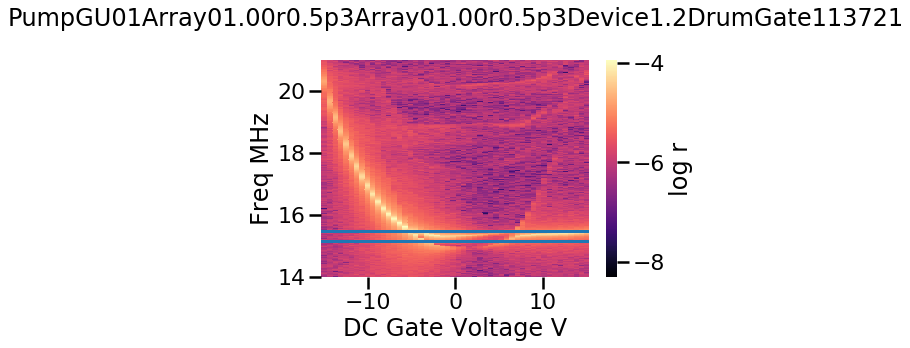

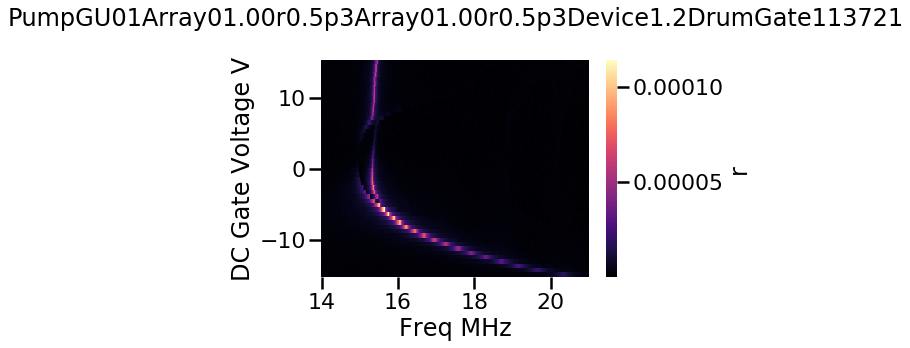

In [2]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)  

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(9)

p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
#sns.heatmap(p)

"""
Vpowplot plots rlog versus frequency after calculating the voltage to the power n.
"""
def Vpowplot(df,n, transpose =False,  offset=0, 
             colname = 'Keithley Voltage', nicecolname = 'DC Gate Voltage V', values='rlog', **kwargs):
    if (-1)**n == -1:
        df['('+ nicecolname +')^' + str(n)] = ((df[colname])**n).round(9)
        nthlog = df.pivot_table(index = '('+ nicecolname +')^' + str(n), columns = 'Freq MHz', 
                            values = values).sort_index(axis = 0, ascending = False) 
    else:
        ## Need to explicitly separate positive and negative voltages.
        posdf = df[df[colname]>0]
        negdf = df[df[colname]<0]
        posdf['(' + nicecolname + ')^' + str(n)] = ((posdf[colname])**n).round(9)
        negdf['(' + nicecolname +')^' + str(n)] = -((negdf[colname])**n).round(9)
        posnthlog = posdf.pivot_table(index = '('+ nicecolname +')^' + str(n), columns = 'Freq MHz', 
                            values = values).sort_index(axis = 0, ascending = False) 
        negnthlog = negdf.pivot_table(index = '('+ nicecolname +')^' + str(n), columns = 'Freq MHz', 
                            values = values).sort_index(axis = 0, ascending = False) 
        nthlog = pd.concat([posnthlog,negnthlog])
    if offset:
        nthlog = offsetindex(nthlog, offset, '(Voltage diff)^' + str(n))
    plt.figure()
    if transpose:
        myheatmap(nthlog.transpose(), 'log r',  **kwargs)
    else:
        myheatmap(nthlog, 'log r',  **kwargs)


plt.figure()
ax = myheatmap(p.transpose(),'log r',)
plt.title(file + '\n');
ax.axhline(15.16)
ax.axhline(15.5)

# This is the same heatmap as shown above except it shows r instead of log(r)

plt.figure()
p2 = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(p2, 'r', )
plt.title(file + '\n');

"""ax = Vpowplot(df, 2)
#ax.set_frame_on(False)
Vpowplot(df, 2.5)
Vpowplot(df, 3)
#Vpowplot(df, 3, transpose=True)

Vpowplot(df, 4)
Vpowplot(df, 5)
Vpowplot(df, 6)
Vpowplot(df, 8)""";

Gate voltage: -3.979493 V


31

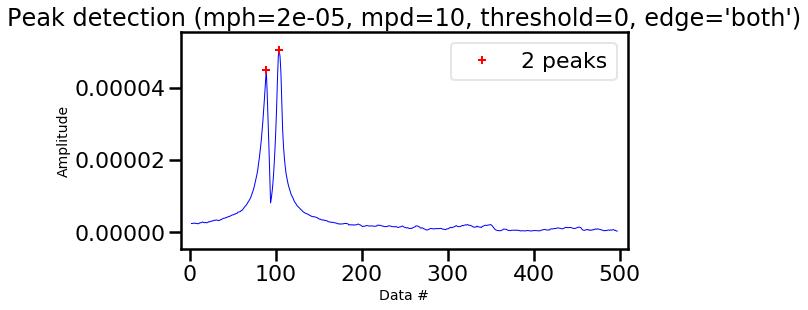

[89, 104]
Float64Index([15.248496994, 15.458917836], dtype='float64', name='Freq MHz')


0.21042084199999955

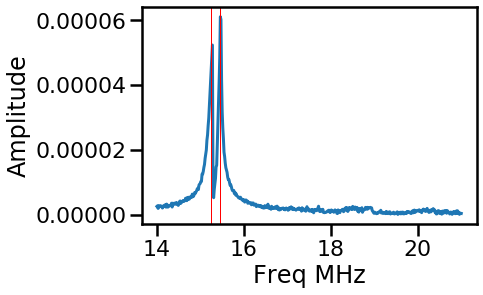

In [3]:
i = 31
if True:
    print("Gate voltage: " + str(p2.iloc[i].name) + " V")
    data = p2.iloc[i]
    display(i)
    ## Manual adjustement
    if True:
        mph = 2e-5;
        #print(mph)
        mpd = 10
    if True:
        window = 5;
    res = detect_peaks(pd.DataFrame.rolling(data, window, center=True).sum()/window, 
             mph=mph, 
             #threshold=1e-9,
             mpd=mpd,
             edge = 'both',
             show=True)
    #print(res)
    if True:
        res = list(res)
    print(res)
    
data.plot()
plt.ylabel('Amplitude')
for j in p2.columns[res[:]]:
    plt.axvline(x=j, color='r', linewidth=1)
print(p2.columns[res[:]])

p2.columns[res[1]] - p2.columns[res[0]]

In [4]:
"""voltslist = []
voltpeakints = []

i = 250
window = 1
mph = 1e-6
mpd = 2
#p2.iloc[:,i].plot()

if True:
#for i in range(len(p2.columns)):
    data = p2.iloc[:,i]
    print(str(data.name) + " MHz")
    res = detect_peaks(pd.DataFrame.rolling(data, window, center=True).sum()/window, 
             mph=mph, 
             #threshold=1e-7,
             mpd=mpd,
             edge = 'both',
             show=True)
    print(res)
    res = list(res)
    voltpeakints.append(res[:])
    voltslist.append(p2.index[res[:]])""";

In [5]:
"""peakfreqsp3 = pd.DataFrame(voltslist, index = p2.columns,)# columns = p2.columns)#, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])

#pfsp3 = peakfreqsp3.loc[15.5:18.1]
#display(pfsp3.head())

peakfreqsp3.plot(marker='.', color='k', alpha=0.2, linestyle=None, linewidth=0, legend=False)
myheatmap(p,'log r')
plt.title(file + '\n');
""";

In [6]:
# initialize peaks list
peaksint = []
freqlist = []

verbose = False


for i in range(len(p2)):
    data = p2.iloc[i]
    if verbose:
        display(i)
        print("Gate voltage: " + str(p2.iloc[i].name) + " V")
    ## Manual adjustement
    if i<33:
        mph = 1.5e-6;
        #print(mph)
        mpd = 10
    else:
        mph = 5e-6;
        mpd = 15;
    if True:
        window = 5;
    res = detect_peaks(pd.DataFrame.rolling(data, window, center=True).sum()/window, 
             mph=mph, 
             #threshold=1e-7,
             mpd=mpd,
             edge = 'both',
             show=verbose)
    #print(res)
    if i==33 or i == 35 or i == 47 or i == 49:
        res = list(res)
    elif i == 34 or (i >= 36 and i <= 40) or i == 42 or i == 44 or i == 46:
        res = list(res[j] for j in [1])
    elif i == 18 or i == 19 or i == 20:
        res = list(res[j] for j in [0,2,3])
    elif i == 0:
        res = list(res[j] for j in [2,5])
    elif i == 1:
        res = list(res[j] for j in [3,5])
    elif i == 2:
        res = list(res[j] for j in [3,6,7]) # not sure about 6 and 7
    elif i == 3:
        res = list(res[j] for j in [4,7])
    elif i == 4:
        res = list(res[j] for j in [2])
    elif i == 5:
        res = list(res[j] for j in [3,6]) #?
    elif i == 6:
        res = list(res[j] for j in [3,7,8,9])
    elif i == 7:
        res = list(res[j] for j in [3,7,8])
    elif i == 8:
        res = list(res[j] for j in [2,8, 9,10]) #8?
    elif i == 9:
        res = list(res[j] for j in [2,7,8,10])
    elif i == 10:
        res = list(res[j] for j in [3,7,8,9])
    elif i == 11:
        res = list(res[j] for j in [2,5,6,7])
    elif i == 12:
        res = list(res[j] for j in [1,2,3,4])
    elif i == 13:
        res = list(res[j] for j in [2,3,4,5])
    elif i == 14:
        res = list(res[j] for j in [1,2,3,4])
    elif i == 15:
        res = list(res[j] for j in [2,3,5,6])
    elif i == 16:
        res = list(res[j] for j in [1,2,4,5])
    elif i == 17:
        res = list(res[j] for j in [1,3,4,5])
    elif i == 22:
        res = list(res[j] for j in [0,2,4])
    elif i == 23:
        res = list(res[j] for j in [1,2,5])
    elif i == 24:
        res = list(res[j] for j in [1,2,5])
    elif i == 25:
        res = list(res[j] for j in [3,4,8])
    elif i == 26:
        res = list(res[j] for j in [3,4,8,9])
    elif i == 27:
        res = list(res[j] for j in [4,5,10,11])
    elif i == 28:
        res = list(res[j] for j in [4,5,13,14])
    elif i == 29:
        res = list(res[j] for j in [4,5,15,16])
    elif i == 30 or i == 31:
        res = list(res[j] for j in [3,4,16])
    elif i == 32:
        res = list(res[j] for j in [4,5,19])
    elif i == 41 or i == 43:
        res = list(res[j] for j in [2])
    elif i == 45 or i == 48:
        res = list(res[j] for j in [0])
    else:
        res = list(res)
    if verbose:
        print(res)


    freqlist.append(p2.columns[res[:]])
    # shorten results to just 2 peaks
    peaksint.append(res[:])
    #print(peaksint[i])
    
if verbose:
    display(peaksint)
    display(freqlist)

peakfreqsp2 = pd.DataFrame(freqlist, index = p2.index)#, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqsp2


,0,1,2,3
DC Gate Voltage V,,,,
14.999580,15.458918,20.579158,NaN,NaN
14.387710,15.430862,20.396794,NaN,NaN
13.775340,15.430862,20.200401,20.466934,NaN
13.163360,15.416834,20.158317,NaN,NaN
12.550720,15.402806,NaN,NaN,NaN
11.938790,15.402806,19.414830,NaN,NaN
11.326530,15.388778,17.843687,19.358717,20.621242
10.714220,15.388778,17.549098,20.537074,NaN
10.102000,15.388778,17.170341,19.330661,20.438878


PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721


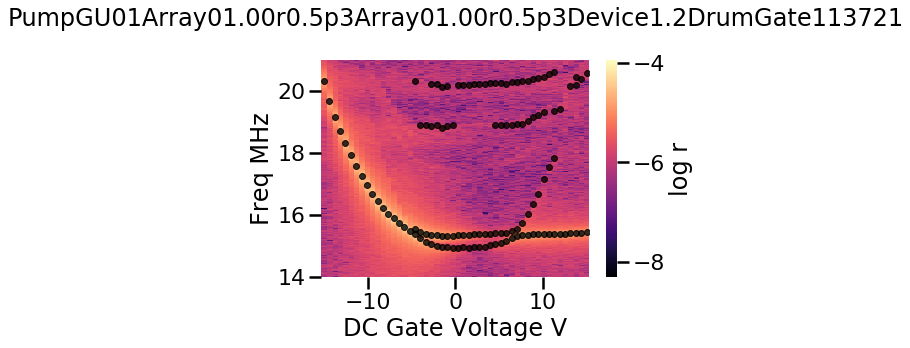

In [7]:
peakfreqsp2.plot(marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0, legend=False)
myheatmap(p.transpose(),'log r')
plt.title(file + '\n');
print(file)

In [8]:
"""peakfreqsp2.plot(marker='.',  alpha=0.8, linestyle=None, linewidth=0, legend=False)
myheatmap(p.transpose(),'log r',
        cmap = 'gray')
plt.title(file + '\n');""";

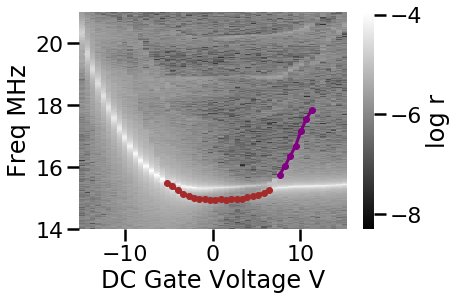

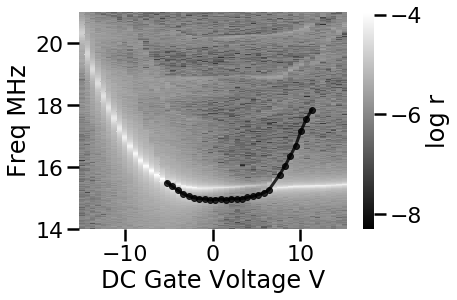

In [9]:
myheatmap(p.transpose(),'log r', cmap = 'gray')

bottomofcurve = peakfreqsp2.iloc[14:34,0]
sideofcurve = peakfreqsp2.iloc[6:13,1]

bottomofcurve.plot(marker ='.', color='brown')
sideofcurve.plot(marker ='.', color = 'purple')

wholecurve = pd.concat([sideofcurve,bottomofcurve])

plt.figure();
myheatmap(p.transpose(),'log r', cmap = 'gray')
wholecurve.plot(marker = '.', color = 'k', alpha = .8) #,linestyle=None, linewidth=0, legend=False)

PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721



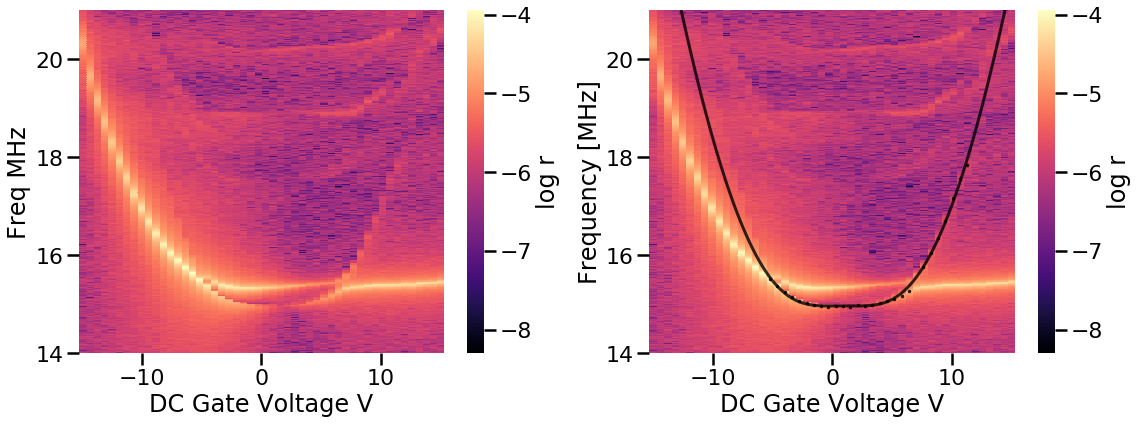

In [10]:

## data to be fit
data=wholecurve.values
x=wholecurve.index.values

## Initial guess for parameters.
params = lmfit.Parameters()
params.add('A', value=100, vary=True)
params.add('B', value=1, vary=True) 
params.add('C', value=1 , vary=True)
params.add('D', value=1, vary=True)
params.add('sigma0', value=1, vary=True)
params.add('offset', value=0, vary=True)

## perform the fit
out = lmfit.minimize(Wresidual, params, args=(x, data),nan_policy='propagate')
display(out) # display all the results

## Plot the fitting result.
V = np.linspace(start=p.index.values.min(), stop=p.index.values.max(), num=1000)
# fit parameters
A = out.params['A'].value  
B = out.params['B'].value  
C = out.params['C'].value  
D = out.params['D'].value  
sigma0 = out.params['sigma0'].value  
offset = out.params['offset'].value  
## display the results
#display(out.params)

##  plot heatmap without and with fit.

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
plt.sca(ax1)
myheatmap(p.transpose(),'log r')

plt.sca(ax2)
myheatmap(p.transpose(),'log r')
wholecurve.plot( marker = '.', markersize=5, color='k',linestyle= 'None', legend=False, alpha = .8)
plt.ylabel("Frequency [MHz]")
plt.plot(V,W(V,A,B,C,D,sigma0, offset), 'k', alpha = .8)
plt.ylim(ymax=21.)

plt.tight_layout()

print(file + '\n')


C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


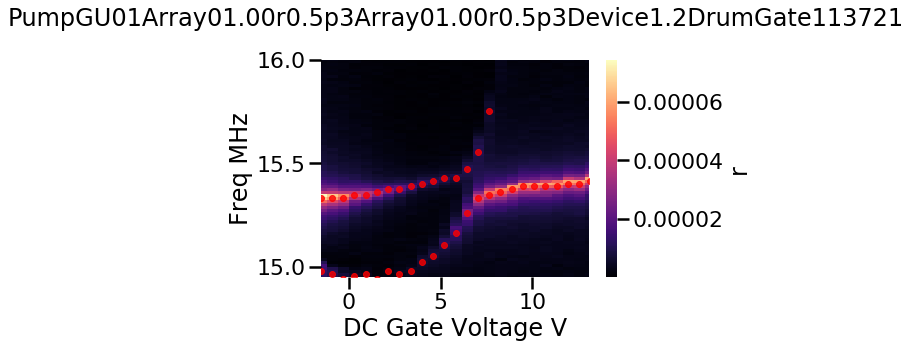

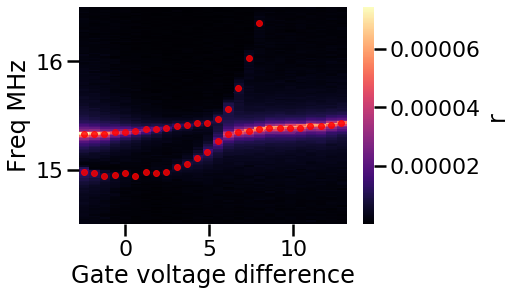

In [11]:
minfreq = 14.5
maxfreq = 16.5
minV = -2
maxV = 14.1
lf = df['Freq MHz'] > minfreq 
hf = df['Freq MHz'] < maxfreq
lv = df['DC Gate Voltage V'] > minV
hv = df['DC Gate Voltage V'] < maxV
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
myheatmap(n.transpose(), 'r')
ax = plt.gca()
plt.title(file + '\n');
peakfreqsp2.plot(marker='.', color='r', alpha=0.8, linestyle=None, linewidth=0, legend=False, ax=ax)
plt.xlim(-1.5,13.1)
plt.ylim(14.95,16);


noffset = offsetindex(n,offset,'Gate voltage difference')
peakfreqsp2offset=offsetindex(peakfreqsp2,offset,'Gate voltage difference')

plt.figure()
myheatmap(noffset.transpose(), 'r')
xlimits = plt.xlim()  # return the current xlim
ylimits = plt.ylim()  # return the current ylim
ax = plt.gca()
peakfreqsp2offset.plot(marker='.', color='r', alpha=0.8, linestyle=None, linewidth=0, legend=False, ax=ax )
plt.xlim(xlimits)   # set the xlim to left, right
plt.ylim(ylimits)   # set the ylim to left, right

pospeakfreqsp2 = peakfreqsp2[peakfreqsp2.index>0]
pospeakfreqsp2offset = peakfreqsp2offset[peakfreqsp2offset.index>0]

"""pow=3
Vpowplot(df[lf][hf][lv][hv],pow, transpose = True , offset=offset)
plt.figure()
Vpowplot(df[lf][hf][lv][hv],pow, transpose = True , offset=0)
xlimits = plt.xlim()  # return the current xlim
ylimits = plt.ylim()  # return the current ylim
plt.plot(peakfreqsp2.index**pow,peakfreqsp2,marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0,  )
plt.xlim(xlimits)   # set the xlim to left, right
plt.ylim(ylimits)   # set the ylim to left, right

Vpowplot(df[lf][hf][lv][hv], 4, transpose = True , offset=offset)
plt.figure()
Vpowplot(df[lf][hf][lv][hv], 4, transpose = True)
xlimits4 = plt.xlim()  # return the current xlim
ylimits4 = plt.ylim()  # return the current ylim
plt.plot(pospeakfreqsp2.index**4,pospeakfreqsp2,marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0,  )
plt.xlim(xlimits4)   # set the xlim to left, right
plt.ylim(ylimits4)   # set the ylim to left, right

pow=5
Vpowplot(df[lf][hf][lv][hv], pow, transpose = True , offset=offset)
plt.figure()
Vpowplot(df[lf][hf][lv][hv], pow, transpose = True )
xlimits = plt.xlim()  # return the current xlim
ylimits = plt.ylim()  # return the current ylim
plt.plot(peakfreqsp2.index**pow,peakfreqsp2,marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0,  )
plt.xlim(xlimits)   # set the xlim to left, right
plt.ylim(ylimits)   # set the ylim to left, right""";

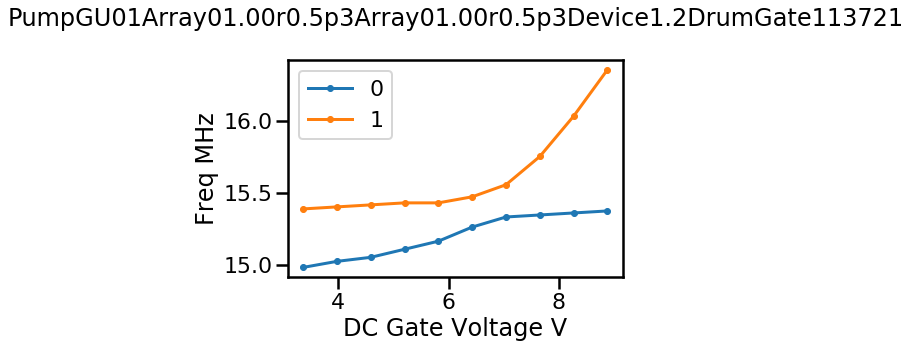

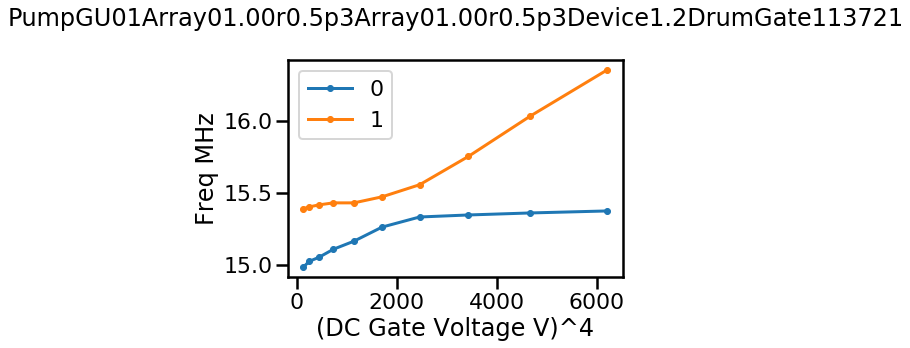

In [12]:
minV = 3
maxV = 9
lf = pospeakfreqsp2 > minfreq 
hf = pospeakfreqsp2 < maxfreq
lv = pospeakfreqsp2.index > minV
hv = pospeakfreqsp2.index < maxV

zoomedpeakfreqsp2 = (pospeakfreqsp2[lf][hf][hv]).iloc[:,0:2]
lv = zoomedpeakfreqsp2.index > minV
zoomedpeakfreqsp2 = zoomedpeakfreqsp2[lv]

zoomedpeakfreqsp2.plot(marker ='.')
plt.title(file + '\n');
plt.ylabel('Freq MHz')

pow4zoomedpeakfreqsp2 = zoomedpeakfreqsp2.copy()
pow4zoomedpeakfreqsp2.index = zoomedpeakfreqsp2.index**4
pow4zoomedpeakfreqsp2.index.name = '(DC Gate Voltage V)^4'


pow4zoomedpeakfreqsp2.plot(marker ='.')
plt.title(file + '\n');
plt.ylabel('Freq MHz');

In [13]:
"""## Manually choose test parameters; these will be the starting points for the fit.
k1 = 10   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = .15    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = 20   # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = 0.1;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.


#dk = np.linspace(-1,1 , 1000)
#dk = peakfreqsp.index.values
dk = np.linspace(pow4zoomedpeakfreqsp2.index.values.min(), pow4zoomedpeakfreqsp2.index.values.max(), 1000)
#dk = np.linspace(-10, 1000, 1000)


## Plot the guesses to find a good starting guess
pow4zoomedpeakfreqsp2.plot( marker = '.', linestyle = 'None', legend=None)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,middle1(dk, m1,m2,k,k1), 'gray')

del m1,m2,k,k1,dk""";

array([16.35671343, 16.03406814, 15.75350701, 15.55711423, 15.47294589,
       15.43086172, 15.43086172, 15.41683367, 15.40280561, 15.38877756])

array([15.3747495 , 15.36072144, 15.34669339, 15.33266533, 15.26252505,
       15.16432866, 15.10821643, 15.05210421, 15.0240481 , 14.98196393])

array([6210.46019373, 4667.00729046, 3430.35714314, 2457.87800039,
       1707.76372236, 1144.57024036,  733.48664916,  444.68428175,
        250.78918134,  128.60084731])

(14.497995992000002, 16.5)

<Figure size 432x288 with 0 Axes>

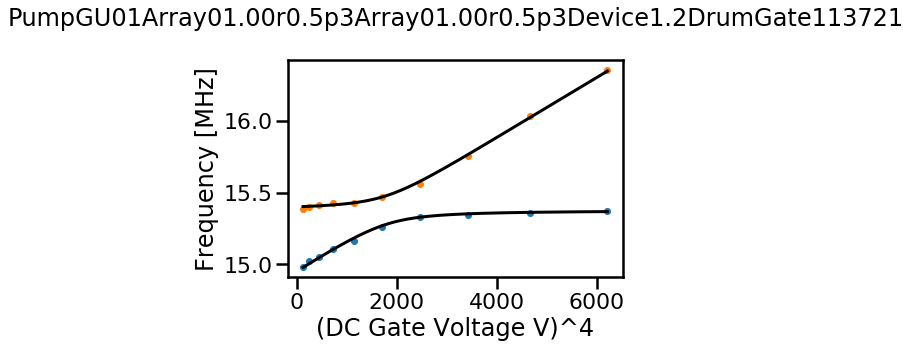

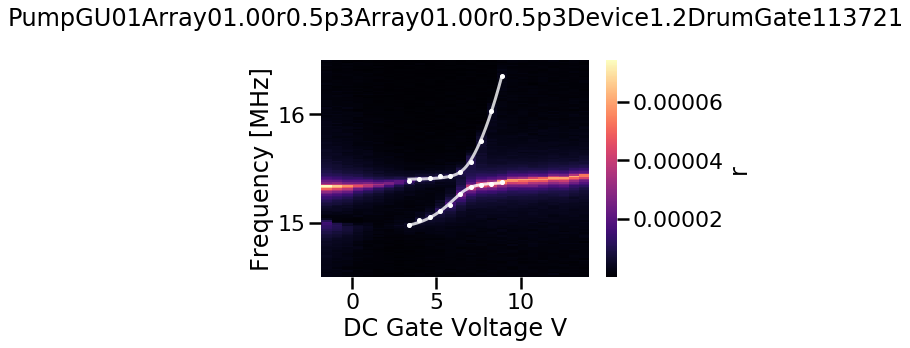

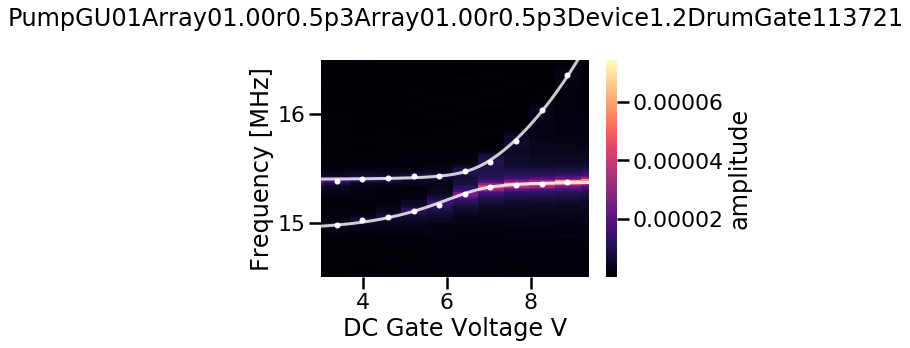

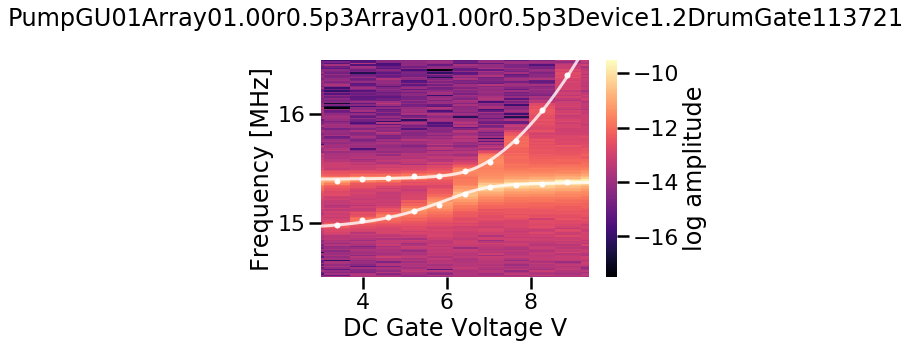

In [14]:
#upperantim = lmfit.Model(upperantifn)
#lowerantim = lmfit.Model(lowerantifn)

# input guesses for the fitting parameters
params2 = lmfit.Parameters()
params2.add('k1', value=10, vary=True)
params2.add('m1', value=.15, vary=True) 
params2.add('m2', value=20 , vary=True)
params2.add('k', value=0.1, vary=True, min=0)

"""## plot the data
myheatmap((pow4zoomedpeakfreqsp2).transpose(), cmap = 'gray') # cutting out last row because it is incomplete
pow4zoomedpeakfreqsp2.plot( marker = '.',  linestyle= 'None', legend=True)
plt.title(file + '\n');"""

## data to be fit
dat1=pow4zoomedpeakfreqsp2.iloc[:,1].values
dat2=pow4zoomedpeakfreqsp2.iloc[:,0].values
x=pow4zoomedpeakfreqsp2.index.values

display(dat1)
display(dat2)
display(x)

## perform the fit
out = lmfit.minimize(anticrossingresidual, params2, args=(x, dat1, dat2),nan_policy='propagate')
display(out) # display all the results

## Plot the fitting result.
dk = np.linspace(pow4zoomedpeakfreqsp2.index.values.min(), pow4zoomedpeakfreqsp2.index.values.max(), 500)
# fit parameters
k1 = out.params['k1'].value   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = out.params['m1'].value    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = out.params['m2'].value    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = out.params['k'].value;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

## display the results
#display(out.params)


##  plot without heatmap
plt.figure();
pow4zoomedpeakfreqsp2.plot( marker = '.', linestyle= 'None', legend=False)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')




plt.figure()
ax = myheatmap(n.transpose(), 'r')
zoomedpeakfreqsp2.plot(color='white', marker = '.',markersize=8, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
#del m1,m2,k,k1,dk

plt.figure()
dk = np.linspace(0, pow4zoomedpeakfreqsp2.index.values.max()+2000, 500)
ax = myheatmap((n.transpose()), 'amplitude')#, cmap = 'Seismic')
zoomedpeakfreqsp2.plot(color='white', marker = '.',markersize=10, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.xlim(3,9.4)
plt.ylim(ymax=16.5)

plt.figure()
ax = myheatmap(np.log(n.transpose()), 'log amplitude')#, cmap = 'Seismic')
zoomedpeakfreqsp2.plot(color='white', marker = '.',markersize=10, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.xlim(3,9.4)
plt.ylim(ymax=16.5)


PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721


(14.497995992000002, 16.504008016)

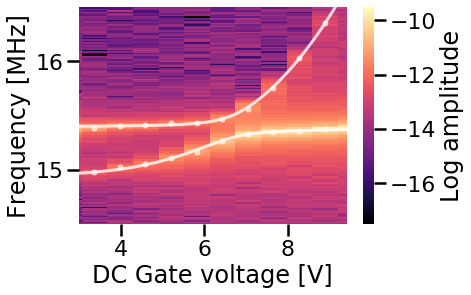

In [15]:
## considering variations on the plot

normconst = n.max().max()
color = 'w'
data = np.log(n)
ax = myheatmap(((data).transpose()), 'Log amplitude',cmap='magma')#, cmap = 'Seismic')
zoomedpeakfreqsp2.plot(color=color, alpha = .6, marker = '.', markersize=10, 
                       linestyle= 'None', linewidth=0.5, legend=False, ax=ax)
ylims = plt.ylim()
plt.ylabel("Frequency [MHz]")
plt.xlabel("DC Gate voltage [V]")
print(file)
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), color=color, alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), color=color, alpha = .8)
plt.xlim(3,9.4)
plt.ylim(ylims)

File not overwritten:
\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports\PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721_fullfig.pdf
File not overwritten:
\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports\PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721_anticrossingfit.pdf


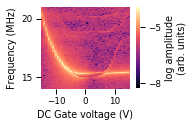

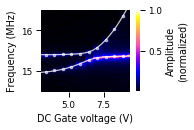

In [16]:
sns.set_context('paper')

plt.figure(figsize=(2,1.5))
ax, cbar =myheatmap(p.transpose(),'log amplitude\n(arb. units)',cmap = 'magma',return_cbar=True)
cbar.set_ticks([-8, -5])
plt.ylabel("Frequency (MHz)")
plt.xlabel("DC Gate voltage (V)")
#plt.title(file + '\n');

if saving_all:
    ## save pdf of figure
    plt.savefig(os.path.join(savefolder,file + '_fullfig.pdf'), dpi=None, facecolor='w', edgecolor='w',
            transparent=False, bbox_inches='tight', pad_inches=0.05,
            metadata=None)

    print('File saved:')
else:
    print('File not overwritten:')
print(os.path.join(savefolder,file + '_fullfig.pdf'))

plt.figure(figsize=(2,1.5))
normconst = n.max().max()
ax = myheatmap(((n/normconst).transpose()), 'Amplitude\n(normalized)', cmap = 'gnuplot2')#, cmap = 'Seismic')
zoomedpeakfreqsp2.plot(color='white', alpha = .6, marker = '.', markersize=5, 
                       linestyle= 'None', linewidth=0.5, legend=False, ax=ax)
ylims = plt.ylim()
plt.ylabel("Frequency (MHz)")
plt.xlabel("DC Gate voltage (V)")
#print(file)
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.xlim(3,9.4)
plt.ylim(ylims)
#del m1,m2,k,k1,dk


if saving_all:
    # save pdf of figure
    plt.savefig(os.path.join(savefolder,file + '_anticrossingfit.pdf'), dpi=None, facecolor='w', edgecolor='w',
            transparent=False, bbox_inches='tight', pad_inches=0.05,
            metadata=None)


    print('File saved:')
else:
    print('File not overwritten:')
print(os.path.join(savefolder,file + '_anticrossingfit.pdf'))

# store info in dict
bigdrum_V = {'file': file,
                'dk': dk,
                'm1': m1,
                'm2': m2,
                'k': k,
                'k1': k1,
                'xlabel': "DC Gate voltage (V)",
                'ylabel': "Frequency (MHz)",
                'xlims': (3,9.4),
                'ylims': ylims,
                'heatmapdf': (n/normconst).transpose(), 
                'datapoints': zoomedpeakfreqsp2,
               }

sns.set_context('poster') # larger font going forward

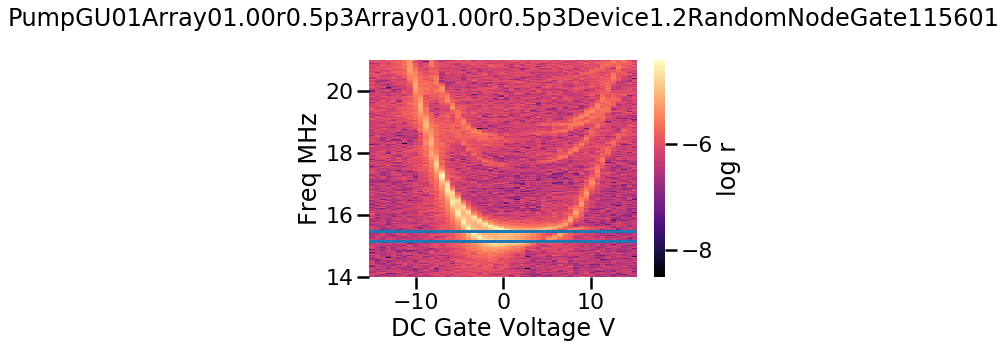

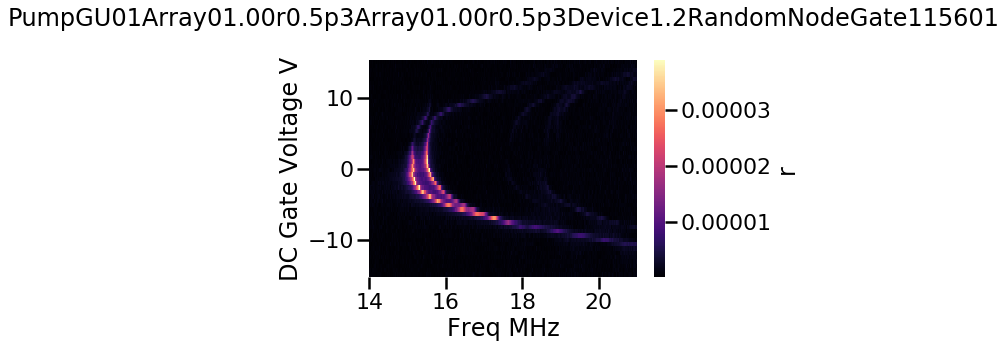

In [17]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601'
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(9)
p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
p3 = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
ax = myheatmap(p.transpose(), 'log r')
ax.axhline(15.16)
ax.axhline(15.5)
plt.title(file + '\n');
plt.figure()
myheatmap(p3, 'r')
plt.title(file + '\n');

In [18]:
# initialize peaks list
peaksint = []
freqlist = []

verbose = False

for i in range(len(p3)):
    data = p3.iloc[i]
    if verbose:
        display(i)
        print("Gate voltage: " + str(p3.iloc[i].name) + " V")
    ## Manual adjustement
    if i <= 3:
        mph = 1e-6
        mpd = 8
    elif i == 7:
        mph = 2e-6
        mpd = 10
    elif i == 8:
        mph = 1e-6
        mpd = 10
    elif i == 32:
        mph = 2e-6
        mpd = 20
    elif i == 34:
        mph = 2e-6
        mpd = 8
    elif i == 38:
        mph = 2e-6
        mpd = 10
    elif i == 35:
        mph = 4e-6
        mpd = 7
    elif i >=43:
        mph = .8*data.max();
        print(mph)
        mpd = 10
    elif i >= 36:
        mph = 3e-6
        mpd = 10
    else:
        mph = 1.5e-6
        mpd = 10
    if i == 35:
        window = 1
    else:
        window = 5;
    res = detect_peaks(pd.DataFrame.rolling(data, window, center=True).sum()/window, 
             mph=mph, 
           #  threshold=1e-8,
             mpd=mpd,
             edge = 'both',
             show=verbose)
    if verbose:
        print(res)
    ## seriously manually selected for this dataset
    if i ==27 or i == 28 or i ==29:
        res = list(res[j] for j in [2,4,5,6,7])
    elif i == 3:
        res = list(res[j] for j in [1,3,4,5,6])
    elif i == 4:
        res = list(res[j] for j in [0,1,2,4,6])
    elif i == 5:
        res = list(res[j] for j in [0,1,2,4,5,6])
    elif i == 8:
        res = list(res[j] for j in [0,2,4,5,7,8,14])
    elif i == 11:
        res = list(res[j] for j in [0,1,3,4,5])
    elif i == 12:
        res = list(res[j] for j in [0,1,3,4])
    elif i == 13:
        res = list(res[j] for j in [1,2,3,4,5])
    elif i == 18 or i==20:
        res = list(res[j] for j in [0,1])
    elif i==19 or i == 21 or i == 37:
        res = list(res[j] for j in [0,2] )
    elif i == 22:
        res = list(res[j] for j in [1,2])
    elif i == 25:
        res = list(res[j] for j in [1,2,3])
    elif i == 26:
        res = list(res[j] for j in [1,3,4])
    elif i == 30:
        res = list(res[j] for j in [1,3,4,5,6])
    elif i == 31:
        res = list(res[j] for j in [2,4,5,6,7])
    elif i == 32 or i == 16:
        res = list(res[j] for j in [1,2,3,4])
    elif i == 33:
        res = list(res[j] for j in [2,3,4,6])
    elif i == 34:
        res = list(res[j] for j in [2,3,4])
    elif i ==35:
        res = list(res[j] for j in [3,4,5] )
    elif i ==38:
        res = list(res[j] for j in [0,1,2,3,6] )
    elif i ==39:
        res = list(res[j] for j in [0,2] )
    elif i ==40 or i == 41:
        res = list(res[j] for j in [1] )
    elif i ==42:
        res = list(res[j] for j in [1,2] )
    else:
        res = list(res)
    if verbose:
        print(res)


    freqlist.append(p3.columns[res[:]])
    # shorten results to just 2 peaks
    peaksint.append(res[:])
    #print(peaksint[i])
    
if verbose:
    display(peaksint)
    display(freqlist)

peakfreqsp3 = pd.DataFrame(freqlist, index = p3.index)#, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqsp3

2.368e-06
1.8544000000000002e-06
1.7032e-06
1.604e-06
1.3304000000000002e-06
1.3464000000000001e-06
1.2432000000000002e-06


,0,1,2,3,4,5,6
DC Gate Voltage V,,,,,,,
14.999600,18.881764,20.382766,20.831663,NaN,NaN,NaN,NaN
14.387730,18.334669,18.797595,20.158317,20.284569,20.663327,20.803607,20.943888
13.775340,18.615230,18.755511,19.877756,20.158317,20.593186,20.803607,20.943888
13.163360,18.545090,19.737475,19.919840,20.509018,20.635271,NaN,NaN
12.550710,18.334669,19.569138,19.723447,20.466934,20.957916,NaN,NaN
11.938790,18.110220,19.428858,19.625251,20.116232,20.523046,20.845691,NaN
11.326540,17.801603,19.162325,19.400802,19.555110,19.765531,20.256513,20.789579
10.714220,17.422846,18.895792,19.218437,19.541082,20.691383,NaN,NaN
10.102010,15.585170,17.072144,17.521042,18.685371,19.176353,19.358717,20.663327


PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601


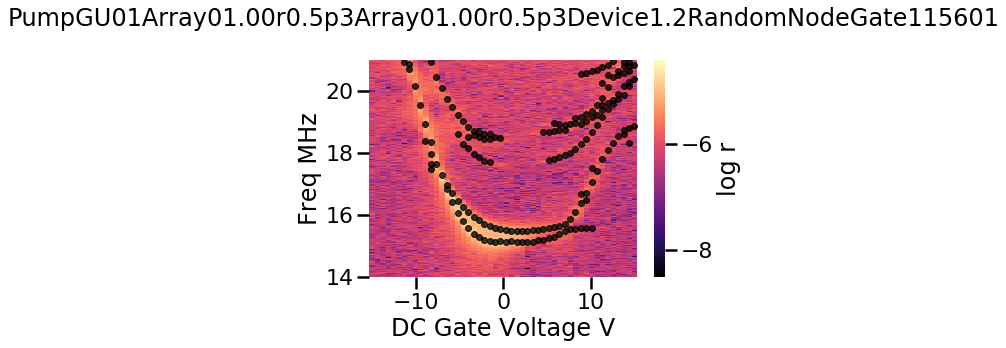

In [19]:
peakfreqsp3.plot(marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0, legend=False)
myheatmap(p.transpose(),'log r')
plt.title(file + '\n');
print(file)

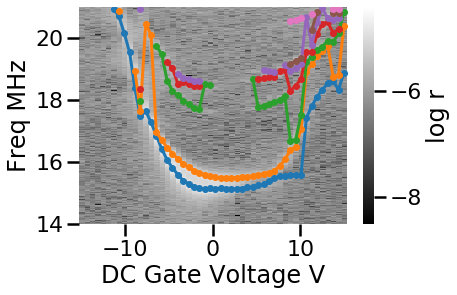

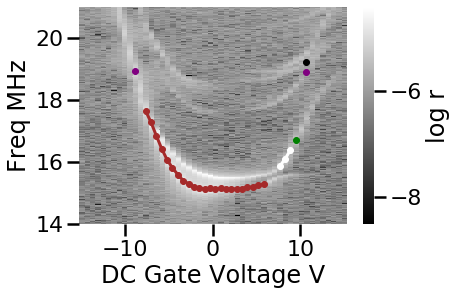

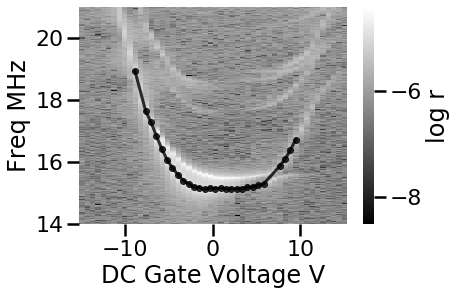

In [20]:
ax = myheatmap(p.transpose(),'log r', cmap = 'gray')
peakfreqsp3.plot(marker ='.', ax=ax, legend=False) 

plt.figure()
myheatmap(p.transpose(),'log r', cmap = 'gray')

leftofcurve = peakfreqsp3.iloc[39:41,1]
bottomofcurve = peakfreqsp3.iloc[15:38,0]
sideofcurve = peakfreqsp3.iloc[7:8,1]
sideofcurve3 = peakfreqsp3.iloc[10:13,1]
sideofcurve2 = peakfreqsp3.iloc[9:10,2]
sideofcurve4 = peakfreqsp3.iloc[7:8,2]



leftofcurve.plot(marker ='.', color='purple')
bottomofcurve.plot(marker ='.', color='brown')
sideofcurve.plot(marker ='.', color = 'purple')
sideofcurve3.plot(marker ='.', color = 'white')
sideofcurve2.plot(marker ='.', color = 'green')
sideofcurve4.plot(marker ='.', color = 'k')


#wholecurve = pd.concat([sideofcurve4,sideofcurve,sideofcurve2,sideofcurve3,bottomofcurve,leftofcurve])
wholecurve = pd.concat([sideofcurve2,sideofcurve3,bottomofcurve,leftofcurve])

wholecurve = wholecurve.dropna()
#display(wholecurve)


plt.figure();
myheatmap(p.transpose(),'log r', cmap = 'gray')
wholecurve.plot(marker = '.', color = 'k', alpha = .8) #,linestyle=None, linewidth=0, legend=False)

In [21]:
"""myheatmap(p.transpose(),'log r', cmap = 'gray')
wholecurve.plot(marker = '.', color = 'k', alpha = .8) #,linestyle=None, linewidth=0, legend=False)

data=wholecurve.values
x=wholecurve.index.values
V = np.linspace(start=-10, stop=10, num=100)

A = 200
B = .5
C = .5
D = 1
sigma0 = 1
offset = 2
plt.plot(V,W(V,A,B,C,D,sigma0, offset), 'k', alpha = .8)
""";

PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601



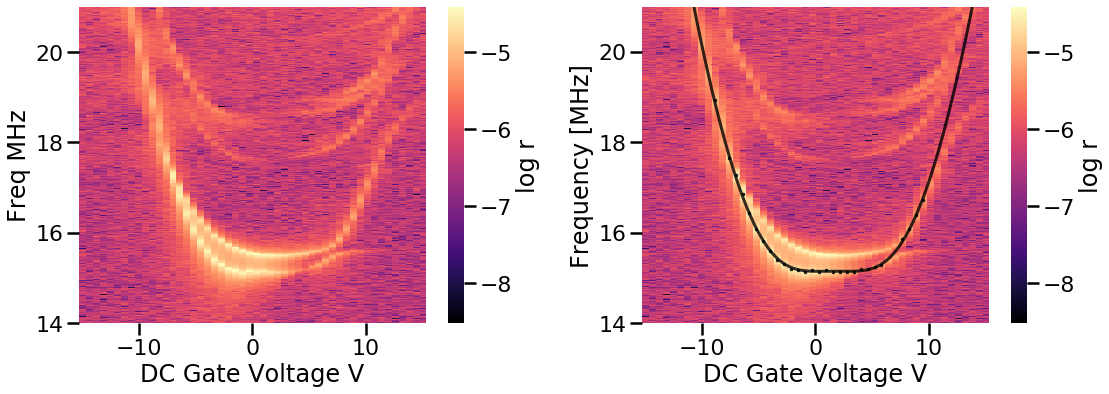

In [22]:

## data to be fit
data=wholecurve.values
x=wholecurve.index.values

## Initial guess for parameters.
params = lmfit.Parameters()
params.add('A', value=230, vary=True)
params.add('B', value=.5, vary=True) 
params.add('C', value=.5 , vary=True)
params.add('D', value=4, vary=True)
params.add('sigma0', value=2, vary=True)#, min=0)
params.add('offset', value=1.557, vary=True)

## perform the fit
out = lmfit.minimize(Wresidual, params, args=(x, data),nan_policy='propagate')
display(out) # display all the results

## Plot the fitting result.
V = np.linspace(start=p.index.values.min(), stop=p.index.values.max(), num=1000)
# fit parameters
A = out.params['A'].value  
B = out.params['B'].value  
C = out.params['C'].value  
D = out.params['D'].value  
sigma0 = out.params['sigma0'].value  
offset = out.params['offset'].value  



## display the results
#display(out.params)


##  plot heatmap without and with fit.

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
plt.sca(ax1)
myheatmap(p.transpose(),'log r')

plt.sca(ax2)
myheatmap(p.transpose(),'log r') 
wholecurve.plot( marker = '.', markersize=5, color='k',linestyle= 'None', legend=False, alpha = .8)
plt.ylabel("Frequency [MHz]")
plt.plot(V,W(V,A,B,C,D,sigma0, offset), 'k', alpha = .8)
plt.ylim(ymax=21.)

plt.tight_layout()

print(file + '\n')



C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher

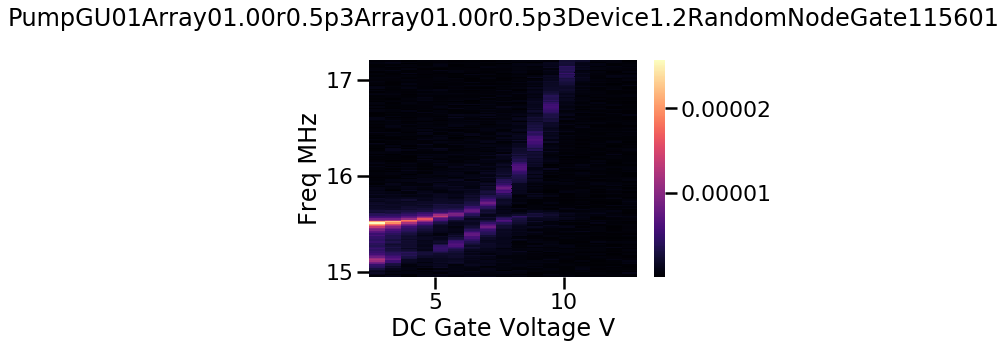

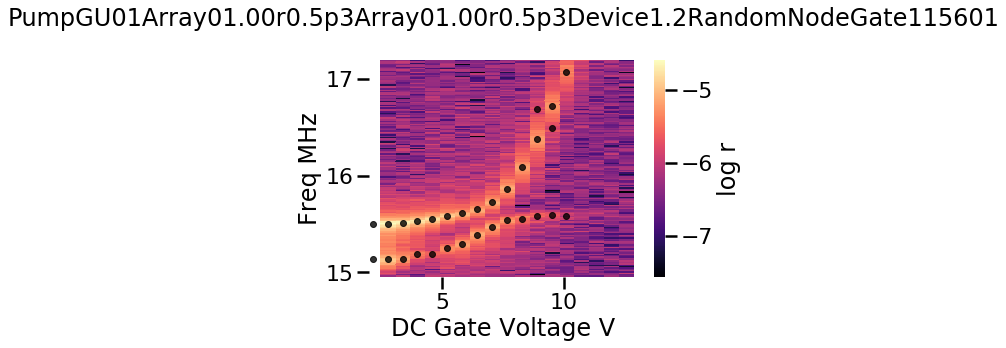

In [23]:
minvoltagep3 = 2.5
maxvoltagep3 = 13.1
lf = df['Freq MHz'] > 14.95 
hf = df['Freq MHz'] < 17.2
lv = df['DC Gate Voltage V'] > minvoltagep3
hv = df['DC Gate Voltage V'] < maxvoltagep3
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
nlog = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False)
myheatmap(n.transpose(), )
plt.title(file + '\n');

plt.figure();
myheatmap(nlog.transpose(), 'log r',)
ax = plt.gca()
peakfreqsp3.plot(marker='.', ax=ax, color='k', alpha=0.8, linestyle=None, linewidth=0, legend=False)
plt.xlim(2., 13.)
plt.ylim(14.95,17.2);
plt.title(file + '\n');
"""
plt.figure()
Vpowplot(n,2, transpose =False, offset=0,)

""";


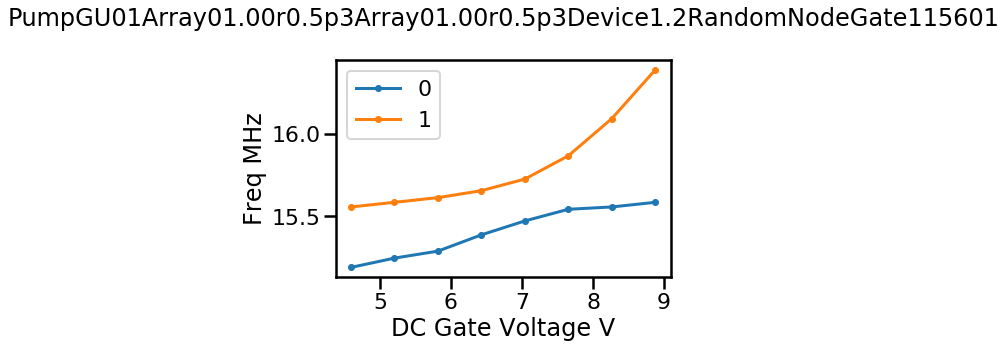

<Figure size 432x288 with 0 Axes>

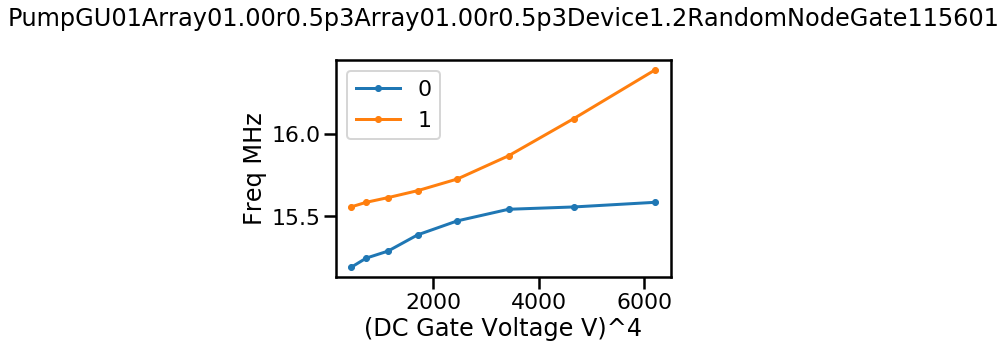

In [24]:
# Select the subset of the data for fitting.
peakfreqsp3fitset = ((peakfreqsp3[peakfreqsp3 < 17])[peakfreqsp3 > 15]).iloc[:,0:2].iloc[10:18]
# plot it.
peakfreqsp3fitset.plot(marker='.')
plt.ylabel('Freq MHz')
plt.title(file + '\n');
peakfreqsp3fitset

pow4peakfreqsp3fitset = peakfreqsp3fitset.copy()
pow4peakfreqsp3fitset.index = peakfreqsp3fitset.index**4
pow4peakfreqsp3fitset.index.name = '(DC Gate Voltage V)^4'

plt.figure()
pow4peakfreqsp3fitset.plot(marker ='.')
plt.title(file + '\n');
plt.ylabel('Freq MHz');

In [25]:
"""## Manually choose test parameters; these will be the starting points for the fit.
k1 = 30   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = .15    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = .15    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = 0.1;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

#dk = np.linspace(-1,1 , 500)
#dk = peakfreqsp.index.values
dk = np.linspace(peakfreqsp3fitset.index.values.min(), peakfreqsp3fitset.index.values.max(), 1000)
#dk = np.linspace(-10, 1000, 1000)


## Plot the guesses to find a good starting guess
peakfreqsp3fitset.plot( marker = '.', linestyle = 'None', legend=None)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,middle1(dk, m1,m2,k,k1), 'gray')


del m1,m2,k,k1,dk""";

array([16.38476954, 16.09018036, 15.86573146, 15.7254509 , 15.65531062,
       15.61322645, 15.58517034, 15.55711423])

array([15.58517034, 15.55711423, 15.54308617, 15.47294589, 15.38877756,
       15.29058116, 15.24849699, 15.19238477])

array([6210.48537896, 4666.9892217 , 3430.34817848, 2457.87939669,
       1707.75947186, 1144.57260173,  733.48777671,  444.69086666])

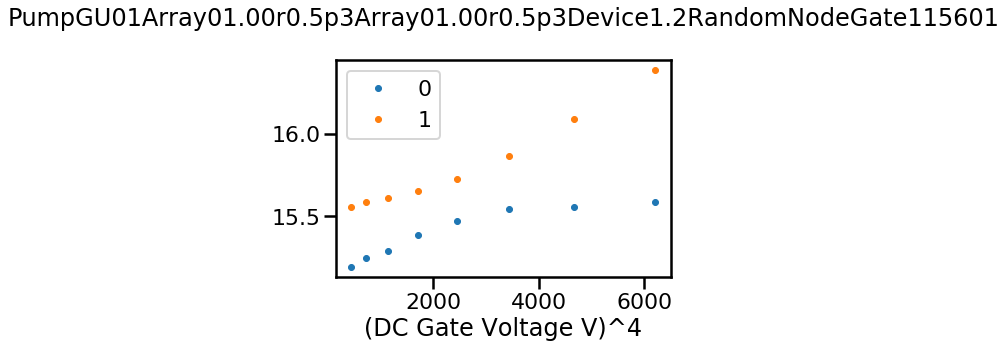

<Figure size 432x288 with 0 Axes>

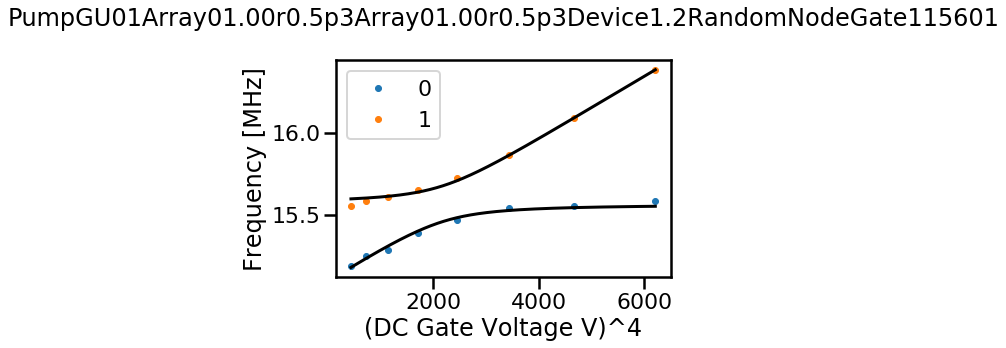

In [26]:
#upperantim = lmfit.Model(upperantifn)
#lowerantim = lmfit.Model(lowerantifn)

# input guesses for the fitting parameters
params2 = lmfit.Parameters()
params2.add('k1', value=30, vary=True)
params2.add('m1', value=.15, vary=True) 
params2.add('m2', value=.15 , vary=True)
params2.add('k', value=1, vary=True, min=0)

## plot the data
#ax = myheatmap((pow4peakfreqsp3fitset).transpose(), cmap = 'gray') # cutting out last row because it is incomplete
pow4peakfreqsp3fitset.plot( marker = '.',  linestyle= 'None', legend=True)
plt.title(file + '\n');

## data to be fit
dat1=pow4peakfreqsp3fitset.iloc[:,1].values
dat2=pow4peakfreqsp3fitset.iloc[:,0].values
x=pow4peakfreqsp3fitset.index.values

display(dat1)
display(dat2)
display(x)

## perform the fit
out = lmfit.minimize(anticrossingresidual, params2, args=(x, dat1, dat2),nan_policy='propagate')
display(out) # display all the results

## Plot the fitting result.
dk = np.linspace(pow4peakfreqsp3fitset.index.values.min(), pow4peakfreqsp3fitset.index.values.max(), 1000)
# fit parameters
k1 = out.params['k1'].value   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = out.params['m1'].value    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = out.params['m2'].value    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = out.params['k'].value;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

## display the results
#display(out.params)


##  plot without heatmap
plt.figure();
pow4peakfreqsp3fitset.plot( marker = '.', linestyle= 'None', legend=True)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')


#del m1,m2,k,k1,dk

(5, 9.8)

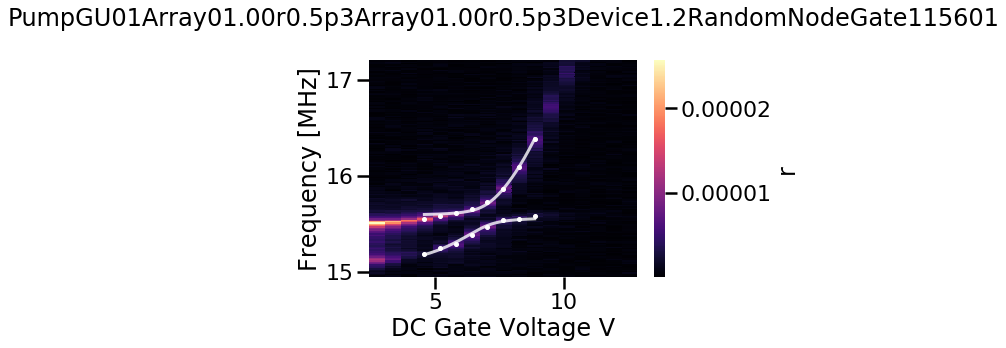

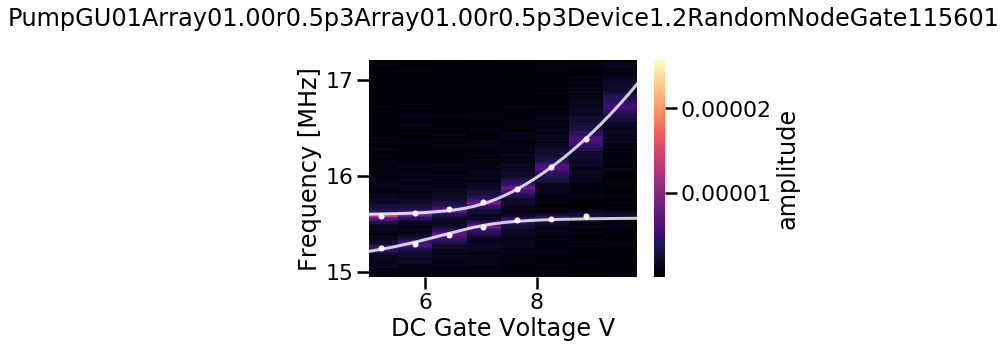

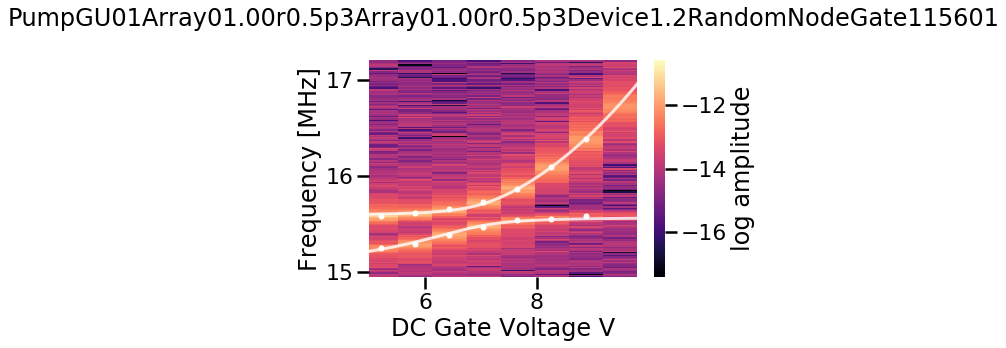

In [27]:

plt.figure()
ax = myheatmap(n.transpose(), 'r')
peakfreqsp3fitset.plot(color='white', marker = '.',markersize=8, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
#del m1,m2,k,k1,dk

plt.figure()
dk = np.linspace(0, pow4peakfreqsp3fitset.index.values.max()+3000, 500)
ax = myheatmap((n.transpose()), 'amplitude')#, cmap = 'Seismic')
peakfreqsp3fitset.plot(color='white', marker = '.',markersize=10, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.xlim(5,9.8)
#plt.ylim(ymax=16.5)

plt.figure()
ax = myheatmap(np.log(n.transpose()), 'log amplitude')#, cmap = 'Seismic')
peakfreqsp3fitset.plot(color='white', marker = '.',markersize=10, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.xlim(5,9.8)
#plt.ylim(ymax=16.5)


File not overwritten:
\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports\PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601_zoomantifit.pdf


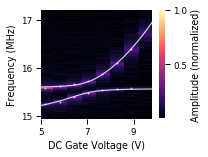

In [28]:
### Make paper-style figure

sns.set_context('paper') # makes text appropriate
### Normalized amplitude, paper-style
plt.figure(figsize=(2.5,2))
normconst = ((n).max().max());
#dk = np.linspace(0, peakfreqsp.index.values.max(), 500)
ax = myheatmap((n/normconst).transpose(), 'Amplitude (normalized)')
peakfreqsp3fitset.plot(color='white', alpha = .6, marker = '.', markersize=2, linestyle= 'None', linewidth=0.5, legend=False, ax=ax)
plt.ylabel("Frequency (MHz)")
plt.xlabel("DC Gate Voltage (V)")
#plt.title(file + '\n')

plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)

#plt.ylim(14.8, 16.2)
plt.xlim(5,9.8)
plt.xticks([5,7,9])

if saving_all:
    ## save pdf of figure
    plt.savefig(os.path.join(savefolder,file + '_zoomantifit.pdf'), dpi=None, facecolor='w', edgecolor='w',
            transparent=False, bbox_inches='tight', pad_inches=0.05,
            metadata=None)

    print('File saved:')
else:
    print('File not overwritten:')
print(os.path.join(savefolder,file + '_zoomantifit.pdf'))

# store info in dict
tinydrum_V = {'file': file,
                'dk': dk,
                'm1': m1,
                'm2': m2,
                'k': k,
                'k1': k1,
                'xlabel': "DC Gate voltage (V)",
                'ylabel': "Frequency (MHz)",
                'xlims': (5,9.8),
                'xticks': ([5,7,9]),
                'heatmapdf': (n/normconst).transpose(), 
                'datapoints': peakfreqsp3fitset,
               }

sns.set_context('poster') # makes text larger going forward.
#del m1,m2,k,k1,dk

In [29]:

"""file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate135906'
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)

df['Blue Laser Power'] = df['DC Offset'].round(9)
p = df.pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap((p.iloc[:-1]).transpose())
plt.title(file + '\n');""";

"plt.figure()\nmyheatmap((p.iloc[7:-1]).transpose())\nplt.title(file + '\n');"

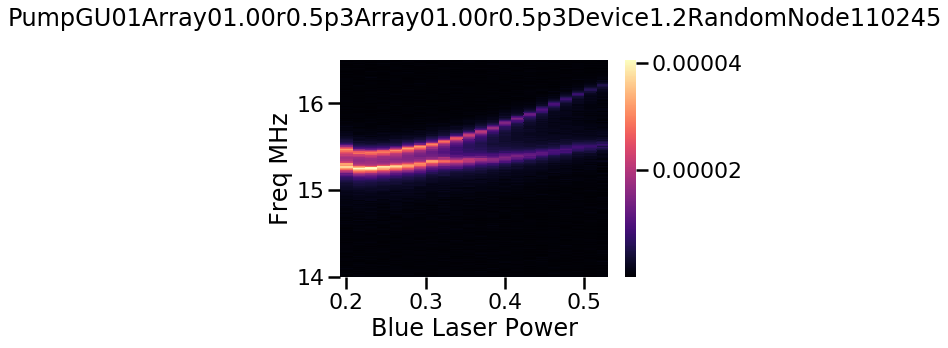

In [30]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNode110245'
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#df.head()

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['Blue Laser Power'] = df['DC Offset'].round(9)
p = df.pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
#p.columns_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 16)

#sns.heatmap(p)
p = p.iloc[:-1]

plt.figure()
myheatmap(p.transpose())
plt.title(file + '\n');

"""plt.figure()
myheatmap((p.iloc[7:-1]).transpose())
plt.title(file + '\n');"""

In [31]:
freqlistp = []
peaksintp = []

verbose = False


## I tweaked this a lot for this particular dataset
for i in range(len(p)):
    print(i)
    if i<6:
        mph = 5e-6
    elif i<12:
        mph = 10e-6
    else:
        mph = 2e-5
    res= detect_peaks(p.iloc[i], 
             mph=mph, 
           #  threshold=1e-8,
             mpd=15,
             edge = 'both',
             show=verbose)
 
    assert (len(res) == 2)

    if True:
        res = list(res)
        
    if verbose:
        print(p.iloc[i].name)
        print(res)
    freqlistp.append(p.columns[res])
    peaksintp.append(res)
    #print(peaksintp[i])

print("\nLoop finished")
print(freqlistp)
print(peaksintp)

peakfreqsp5 = pd.DataFrame(freqlistp, index = p.index, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqsp5

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21

Loop finished
[Float64Index([15.533066132, 16.214428858], dtype='float64', name='Freq MHz'), Float64Index([15.513026052, 16.169338677], dtype='float64', name='Freq MHz'), Float64Index([15.518036072, 16.109218437], dtype='float64', name='Freq MHz'), Float64Index([15.477955912, 16.054108216], dtype='float64', name='Freq MHz'), Float64Index([15.457915832, 16.004008016], dtype='float64', name='Freq MHz'), Float64Index([15.432865731, 15.933867735], dtype='float64', name='Freq MHz'), Float64Index([15.412825651, 15.883767535], dtype='float64', name='Freq MHz'), Float64Index([15.397795591, 15.833667335], dtype='float64', name='Freq MHz'), Float64Index([15.382765531, 15.783567134], dtype='float64', name='Freq MHz'), Float64Index([15.352705411, 15.723446894], dtype='float64', name='Freq MHz'), Float64Index([15.372745491, 15.678356713], dtype='float64', name='Freq MHz'), Float64Index([15.362725451, 15.638276553], dtype='float64', name='Freq

,peak1 freq [MHz],peak2 freq [MHz]
Blue Laser Power,,
0.523077,15.533066,16.214429
0.507692,15.513026,16.169339
0.492308,15.518036,16.109218
0.476923,15.477956,16.054108
0.461538,15.457916,16.004008
0.446154,15.432866,15.933868
0.430769,15.412826,15.883768
0.415385,15.397796,15.833667
0.400000,15.382766,15.783567


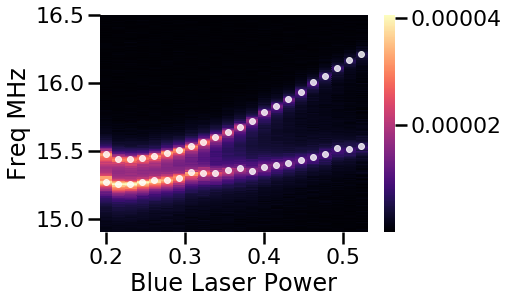

<Figure size 432x288 with 0 Axes>

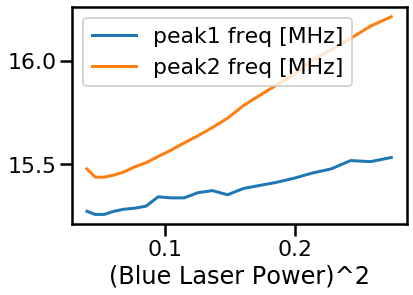

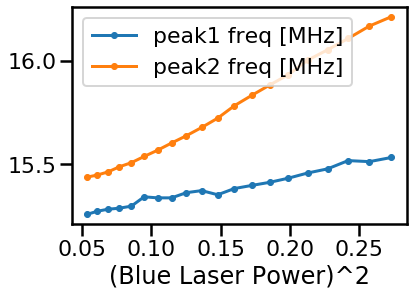

In [32]:
ax = myheatmap(p.transpose())
peakfreqsp5.plot(ax = ax, color='w', legend=None, marker = '.', linestyle = 'None', alpha = .8)
plt.ylim(ymin = 14.9)

peakfreqsp5pow2 = peakfreqsp5.copy()
peakfreqsp5pow2.index = peakfreqsp5.index **2
peakfreqsp5pow2.index.name = '(' + peakfreqsp5.index.name + ')^2'

plt.figure()
(peakfreqsp5pow2).plot()

peakfreqsp5pow2 = peakfreqsp5pow2.iloc[:-2]
(peakfreqsp5pow2).plot(marker ='.')

<Figure size 432x288 with 0 Axes>

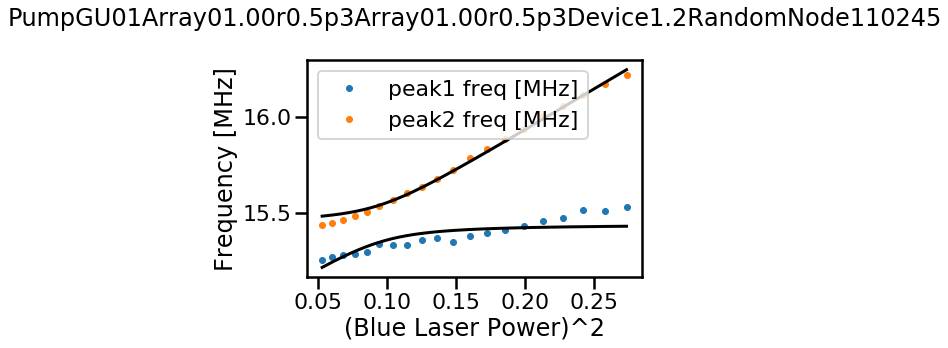

In [33]:


#upperantim = lmfit.Model(upperantifn)
#lowerantim = lmfit.Model(lowerantifn)

# input guesses for the fitting parameters
params1 = lmfit.Parameters()
params1.add('k1', value=1.7, vary=True)
params1.add('m1', value=.0057, vary=True) # should maybe have max 1, but seems to work better without.
params1.add('m2', value=.007 , vary=True)
params1.add('k', value=0.02, vary=True)



## data to be fit
dat1=peakfreqsp5pow2.iloc[:,1].values
dat2=peakfreqsp5pow2.iloc[:,0].values
x=peakfreqsp5pow2.index.values

## perform the fit
out = lmfit.minimize(anticrossingresidual, params1, args=(x, dat1, dat2))
display(out) # display all the results

## Plot the fitting result.
dk = np.linspace(peakfreqsp5pow2.index.values.min(), peakfreqsp5pow2.index.values.max(), 1000)
# test parameters
k1 = out.params['k1'].value   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = out.params['m1'].value    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = out.params['m2'].value    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = out.params['k'].value;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

## display the results
#display(out.params)



## second plot without heatmap
plt.figure();
peakfreqsp5pow2.plot( marker = '.', linestyle= 'None', legend=True)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')


#del m1,m2,k,k1,dk



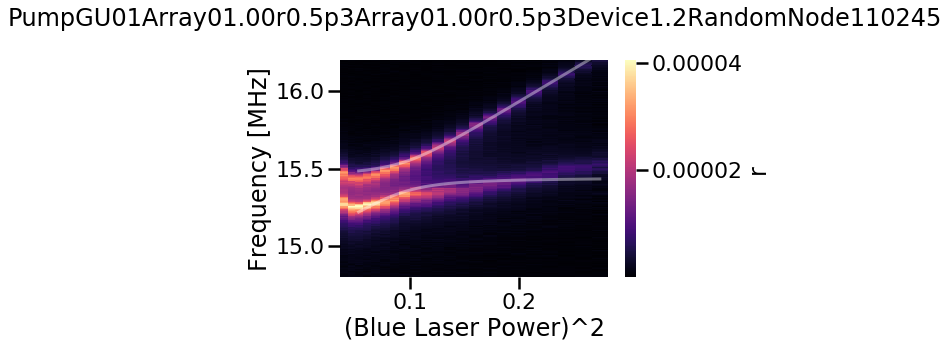

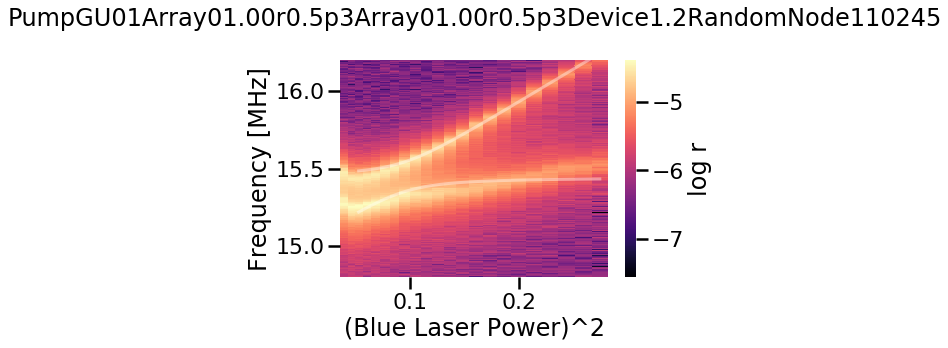

<Figure size 432x288 with 0 Axes>

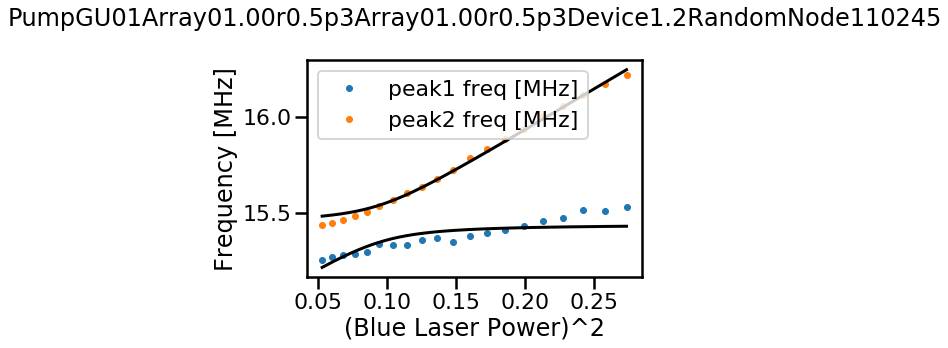

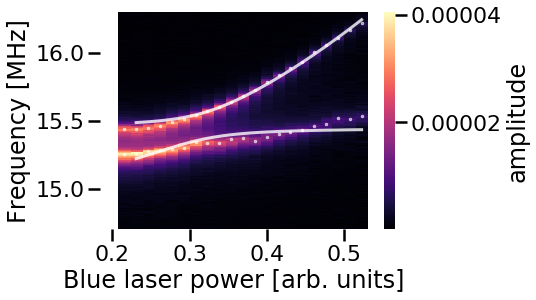

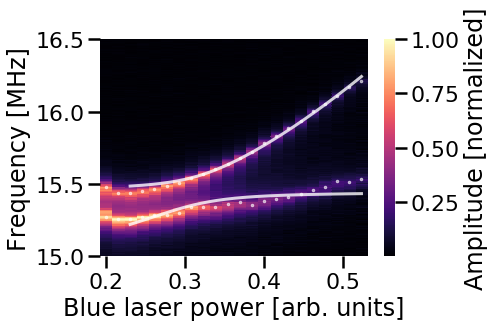

In [34]:
ppow2 = p.copy()
ppow2.index = p.index ** 2
ppow2.index.name = '(Blue Laser Power)^2'

plt.figure()
ax = myheatmap(ppow2.transpose(), 'r') # cutting out last row because it is incomplete
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), color = 'white', alpha=.4)
plt.plot(dk,upperantifn(dk, m1,m2,k,k1),  color = 'white',alpha=.4)
plt.ylim(ymin=14.8,ymax=16.2)

plt.figure()
ax = myheatmap(np.log10(ppow2).transpose(), 'log r') # cutting out last row because it is incomplete
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), color = 'white', alpha=.4)
plt.plot(dk,upperantifn(dk, m1,m2,k,k1),  color = 'white',alpha=.4)
plt.ylim(ymin=14.8,ymax=16.2)

## second plot without heatmap
plt.figure();
peakfreqsp5pow2.plot( marker = '.', linestyle= 'None', legend=True)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')


plt.figure()
#dk = np.linspace(0, peakfreqsp.index.values.max(), 500)
ax = myheatmap((p.iloc[:-1]).transpose(), 'amplitude')
peakfreqsp5.plot(color='white', alpha = .6, marker = '.', markersize=5, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.xlabel("Blue laser power [arb. units]")
#plt.title(file + '\n')
plt.plot(dk**.5,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.5,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.ylim(14.7, 16.3)
#plt.xlim(3,9.4)

### Normalized amplitude
plt.figure()
normconst = ((p).max().max());
#dk = np.linspace(0, peakfreqsp.index.values.max(), 500)
ax = myheatmap((p/normconst).transpose(), 'Amplitude [normalized]')
peakfreqsp5.plot(color='white', alpha = .6, marker = '.', markersize=5, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.xlabel("Blue laser power [arb. units]")
#plt.title(file + '\n')
plt.plot(dk**.5,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.5,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.ylim(15,)
#plt.xlim(3,9.4)


tinydrum_laser = {'file': file,
                  'dk': dk,
                  'm1': m1,
                  'm2': m2,
                  'k': k,
                  'k1': k1,
                  'heatmapdf': (p/normconst).transpose(),
                  'ylabel': "Frequency (MHz)",
                  'xlabel': "Blue laser power (arb. units)",
                  'ylims': (15,),
                  'datapoints': peakfreqsp5,
                 }

,Green X,Green Y,x,y,r,phase,frequency,Output 1 Amplitude,Output 1 Frequency,Output 2 Amplitude,...,Blue Drive,timestamp,bandwidth,Keithley Current,Keithley Voltage,Analog In 1,Analog In 2,HWP,Power,Time
0,-2.5961,6.657918,-3.760000e-07,0.000002,0.000002,1.813450,1.400000e+07,0.0,1.577889e+07,0.199998,...,3.0,4.119137e+14,9.882162,-4.000000e-09,0.000002,-0.009088,-0.004849,0.0,1.0,4.118987e+14
1,-2.5961,6.657918,-3.200000e-07,0.000001,0.000002,1.781926,1.401002e+07,0.0,1.577889e+07,0.199998,...,3.0,4.119137e+14,9.882162,-4.000000e-09,0.000002,-0.009054,-0.004510,0.0,1.0,4.118988e+14
2,-2.5961,6.657918,-4.320000e-07,0.000001,0.000002,1.855520,1.402004e+07,0.0,1.577889e+07,0.199998,...,3.0,4.119137e+14,9.882162,-4.000000e-09,0.000002,-0.008613,-0.004273,0.0,1.0,4.118988e+14
3,-2.5961,6.657918,-1.300000e-07,0.000002,0.000002,1.643404,1.403006e+07,0.0,1.577889e+07,0.199998,...,3.0,4.119137e+14,9.882162,-4.000000e-09,0.000002,-0.008850,-0.005019,0.0,1.0,4.118988e+14
4,-2.5961,6.657918,-4.300000e-08,0.000002,0.000002,1.595402,1.404008e+07,0.0,1.577889e+07,0.199998,...,3.0,4.119137e+14,9.882162,-4.000000e-09,0.000002,-0.008952,-0.005120,0.0,1.0,4.118988e+14
5,-2.5961,6.657918,1.900000e-08,0.000002,0.000002,1.559459,1.405010e+07,0.0,1.577889e+07,0.199998,...,3.0,4.119137e+14,9.882162,-4.000000e-09,0.000002,-0.008986,-0.004883,0.0,1.0,4.118989e+14
6,-2.5961,6.657918,1.180000e-07,0.000002,0.000002,1.499389,1.406012e+07,0.0,1.577889e+07,0.199998,...,3.0,4.119137e+14,9.882162,-4.000000e-09,0.000002,-0.008952,-0.004849,0.0,1.0,4.118989e+14
7,-2.5961,6.657918,9.500000e-08,0.000002,0.000002,1.513892,1.407014e+07,0.0,1.577889e+07,0.199998,...,3.0,4.119137e+14,9.882162,-4.000000e-09,0.000002,-0.009223,-0.004815,0.0,1.0,4.118989e+14
8,-2.5961,6.657918,3.850000e-07,0.000002,0.000002,1.332594,1.408016e+07,0.0,1.577889e+07,0.199998,...,3.0,4.119137e+14,9.882162,-4.000000e-09,0.000002,-0.008952,-0.005256,0.0,1.0,4.118990e+14
9,-2.5961,6.657918,2.190000e-07,0.000001,0.000001,1.424357,1.409018e+07,0.0,1.577889e+07,0.199998,...,3.0,4.119137e+14,9.882162,-4.000000e-09,0.000002,-0.008918,-0.004612,0.0,1.0,4.118990e+14


0        0.2
1        0.2
2        0.2
3        0.2
4        0.2
5        0.2
6        0.2
7        0.2
8        0.2
9        0.2
10       0.2
11       0.2
12       0.2
13       0.2
14       0.2
15       0.2
16       0.2
17       0.2
18       0.2
19       0.2
20       0.2
21       0.2
22       0.2
23       0.2
24       0.2
25       0.2
26       0.2
27       0.2
28       0.2
29       0.2
        ... 
21970    0.0
21971    0.0
21972    0.0
21973    0.0
21974    0.0
21975    0.0
21976    0.0
21977    0.0
21978    0.0
21979    0.0
21980    0.0
21981    0.0
21982    0.0
21983    0.0
21984    0.0
21985    0.0
21986    0.0
21987    0.0
21988    0.0
21989    0.0
21990    0.0
21991    0.0
21992    0.0
21993    0.0
21994    0.0
21995    0.0
21996    0.0
21997    0.0
21998    0.0
21999    0.0
Name: DC Offset, Length: 22000, dtype: float64

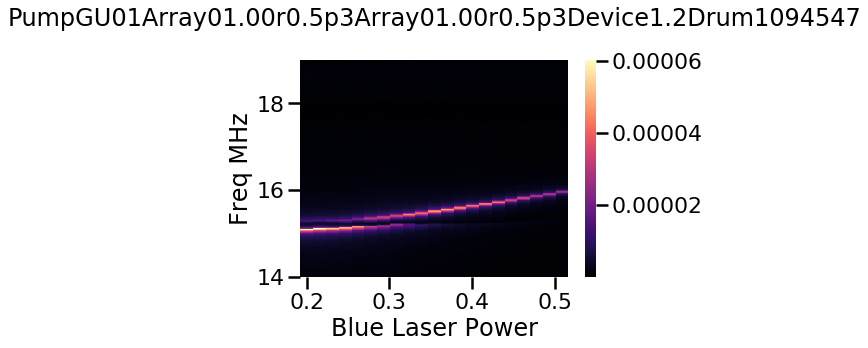

In [35]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1094547'
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

display(df)
display(df['DC Offset'])

## warning: round(2) does not create evenly spaced frequency values.
df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['Blue Laser Power'] = df['DC Offset'].round(9)
p = df.pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap((p.iloc[:-1]).transpose()) # cutting out last laser power because it is incomplete
plt.title(file + '\n');

"""display(df['Blue Laser Power'])
display(p)""";

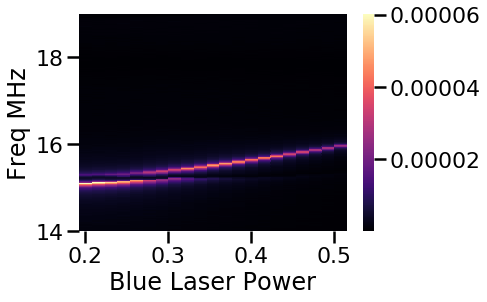

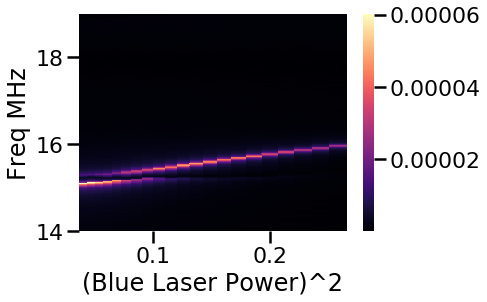

In [36]:
ppow2 = p.iloc[:-1].copy()
ppow2.index = p.iloc[:-1].index ** 2
ppow2.index.name = '(Blue Laser Power)^2'


#sns.heatmap(p.iloc[:-1])
#plt.figure()
myheatmap(p.iloc[:-1].transpose())
plt.figure()
myheatmap(ppow2.transpose())

In [37]:
freqlistp = []
peaksintp = []

verbose = False

## I tweaked this a lot for this particular dataset
for i in range(len(p)):
    if verbose:
        print(i)
    if i < 5:
        mph = 1.2e-6
    elif i < 9:
        mph = 3e-6
    else: 
        mph = 5e-6
    res= detect_peaks(p.iloc[i], 
             mph=mph, 
           #  threshold=1e-8,
             mpd=15,
             edge = 'both',
             show=verbose)
 
    ## I manually picked out the correct peaks
    if i <= 2:
        res = list(res[j] for j in [0,3])
    elif i <= 4:
        res = list(res[j] for j in [1,3] )
    elif i == 16:
        res = list(res[j] for j in [1,2])
    elif i ==21:
        continue
    else:
        res = list(res[j] for j in [0,1])
      
    if verbose:
        print(p.iloc[i].name)
        print(res)
    freqlistp.append(p.columns[res])
    peaksintp.append(res)
    #print(peaksintp[i])
 
if verbose:
    print(freqlistp)
    print(peaksintp)

peakfreqsp = pd.DataFrame(freqlistp, index = p.index[:-1], columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqsp

,peak1 freq [MHz],peak2 freq [MHz]
Blue Laser Power,,
0.507692,15.322645,15.983968
0.492308,15.302605,15.923848
0.476923,15.272545,15.883768
0.461538,15.272545,15.833667
0.446154,15.232465,15.783567
0.430769,15.242485,15.743487
0.415385,15.242485,15.693387
0.400000,15.212425,15.653307
0.384615,15.192385,15.603206


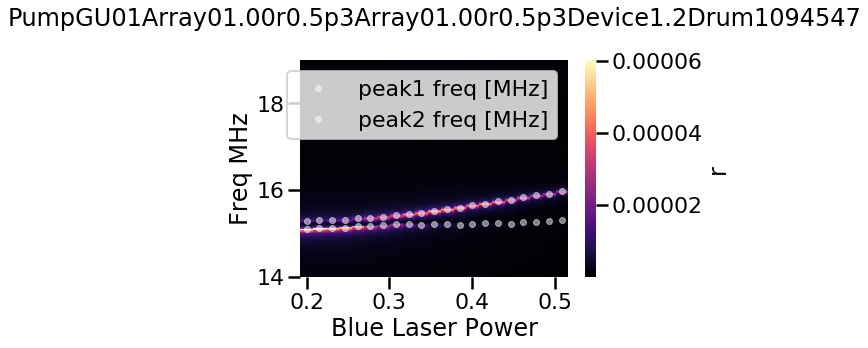

In [38]:
ax = myheatmap((p.iloc[:-1]).transpose(), 'r') # cutting out last row because it is incomplete
peakfreqsp.plot(ax=ax,  marker = '.', color='w', alpha = .5, linestyle= 'None', legend=True)

plt.title(file + '\n');

In [39]:
"""
## Manually choose test parameters; these will be the starting points for the fit.
k1 = 1.3   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = .0057    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = .007    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = 0.01;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.


#dk = np.linspace(-1,1 , 500)
#dk = peakfreqsp.index.values
dk = np.linspace(peakfreqsp.index.values.min(), peakfreqsp.index.values.max(), 1000)
#dk = np.linspace(-10, 1000, 1000)


## Plot the guesses to find a good starting guess
peakfreqsp.plot( marker = '.', linestyle = 'None', legend=None)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1))
plt.plot(dk,upperantifn(dk, m1,m2,k,k1))
plt.plot(dk,middle1(dk, m1,m2,k,k1))


del m1,m2,k,k1,dk
""";

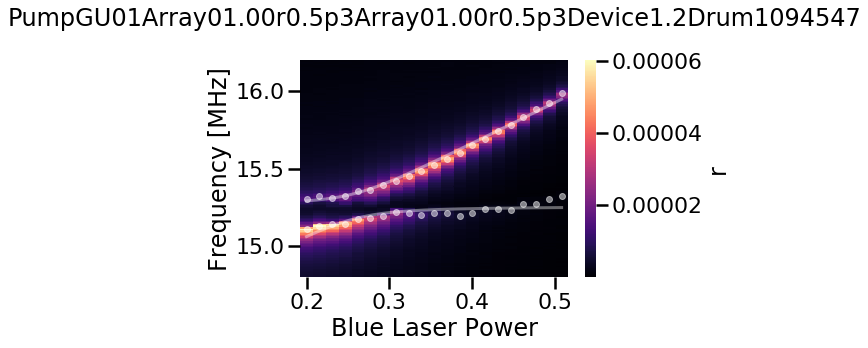

<Figure size 432x288 with 0 Axes>

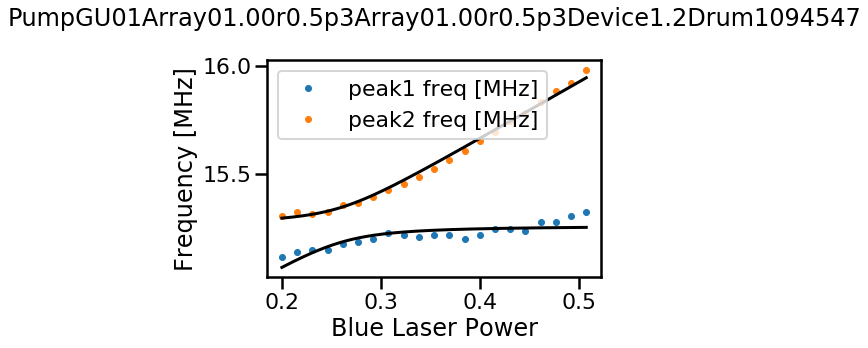

In [40]:
#upperantim = lmfit.Model(upperantifn)
#lowerantim = lmfit.Model(lowerantifn)

# input guesses for the fitting parameters
params1 = lmfit.Parameters()
params1.add('k1', value=1.3, vary=True)
params1.add('m1', value=.0057, vary=True) # should maybe have max 1, but seems to work better without.
params1.add('m2', value=.007 , vary=True)
params1.add('k', value=0.01, vary=True)

## plot the data
ax = myheatmap((p.iloc[:-1]).transpose(), 'r') # cutting out last row because it is incomplete
peakfreqsp.plot(ax=ax, marker = '.', alpha = .5, color = 'white', linestyle= 'None', legend=False)
plt.title(file + '\n');

## data to be fit
dat1=peakfreqsp.iloc[:,1].values
dat2=peakfreqsp.iloc[:,0].values
x=peakfreqsp.index.values

## perform the fit
out = lmfit.minimize(anticrossingresidual, params1, args=(x, dat1, dat2))
display(out) # display all the results

## Plot the fitting result.
dk = np.linspace(peakfreqsp.index.values.min(), peakfreqsp.index.values.max(), 1000)
# test parameters
k1 = out.params['k1'].value   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = out.params['m1'].value    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = out.params['m2'].value    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = out.params['k'].value;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

## display the results
#display(out.params)

#peakfreqsp.plot( marker = '.', linestyle = 'None', legend=None)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), color = 'white', alpha=.4)
plt.plot(dk,upperantifn(dk, m1,m2,k,k1),  color = 'white',alpha=.4)
plt.ylim(ymin=14.8,ymax=16.2)
#plt.plot(dk,middle1(dk, m1,m2,k,k1))

## second plot without heatmap
plt.figure();
peakfreqsp.plot( marker = '.', linestyle= 'None', legend=True)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')


#del m1,m2,k,k1,dk

In [41]:
peakfreqsppow2 = peakfreqsp.copy()
peakfreqsppow2.index = peakfreqsp.index **2
peakfreqsppow2.index.name = '(' + peakfreqsp.index.name + ')^2'

peakfreqsppow2

,peak1 freq [MHz],peak2 freq [MHz]
(Blue Laser Power)^2,,
0.257751,15.322645,15.983968
0.242367,15.302605,15.923848
0.227456,15.272545,15.883768
0.213018,15.272545,15.833667
0.199053,15.232465,15.783567
0.185562,15.242485,15.743487
0.172544,15.242485,15.693387
0.160000,15.212425,15.653307
0.147929,15.192385,15.603206


(14.7, 16.3)

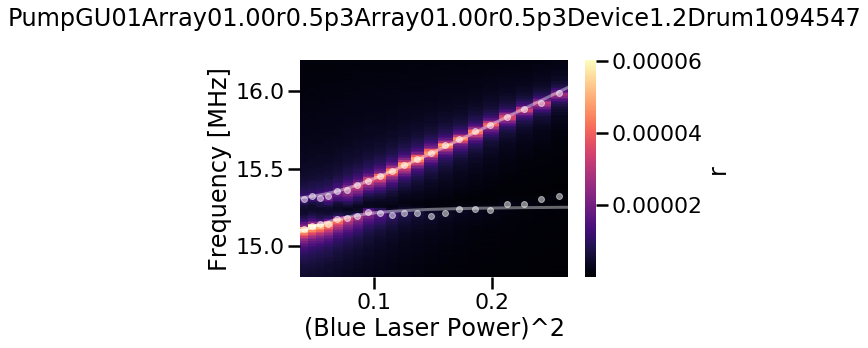

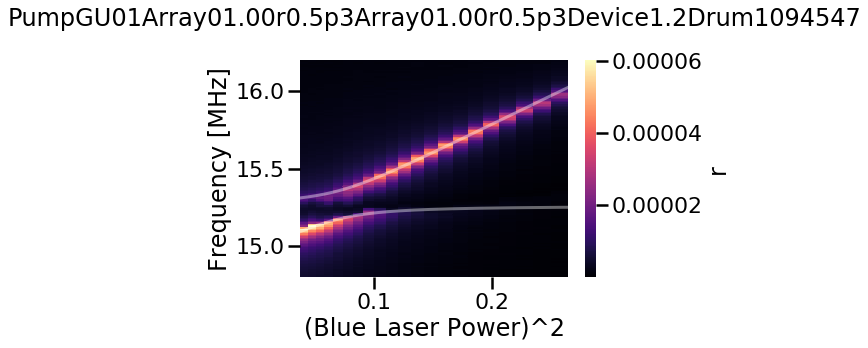

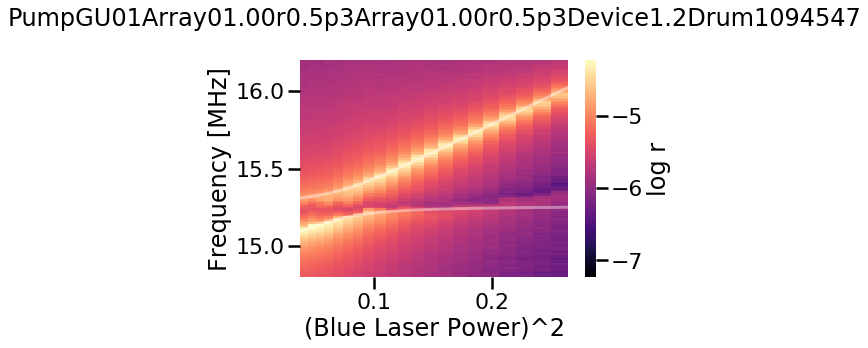

<Figure size 432x288 with 0 Axes>

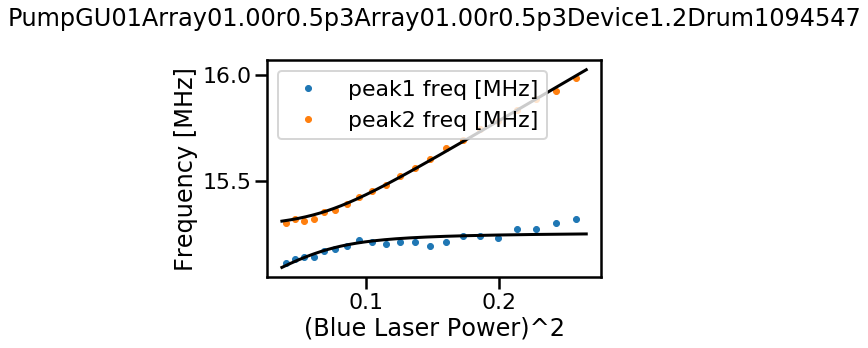

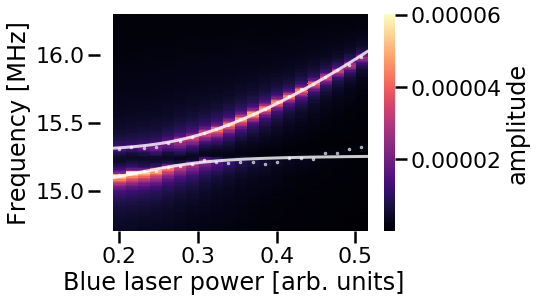

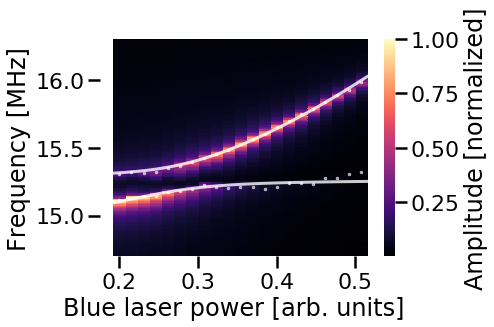

In [42]:
#upperantim = lmfit.Model(upperantifn)
#lowerantim = lmfit.Model(lowerantifn)

# input guesses for the fitting parameters
params1 = lmfit.Parameters()
params1.add('k1', value=1.3, vary=True)
params1.add('m1', value=.0057, vary=True) # should maybe have max 1, but seems to work better without.
params1.add('m2', value=.007 , vary=True)
params1.add('k', value=0.01, vary=True)

## plot the data
ax = myheatmap(ppow2.transpose(), 'r') # cutting out last row because it is incomplete
peakfreqsppow2.plot(ax=ax, marker = '.', alpha = .5, color = 'white', linestyle= 'None', legend=False)
plt.title(file + '\n');
(xmin,xmax) = plt.xlim()

## data to be fit
dat1=peakfreqsppow2.iloc[:,1].values
dat2=peakfreqsppow2.iloc[:,0].values
x=peakfreqsppow2.index.values

## perform the fit
out = lmfit.minimize(anticrossingresidual, params1, args=(x, dat1, dat2))
display(out) # display all the results

## Plot the fitting result.
dk = np.linspace(xmin, xmax, 1000)
# test parameters
k1 = out.params['k1'].value   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = out.params['m1'].value    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = out.params['m2'].value    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = out.params['k'].value;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

## display the results
#display(out.params)

#peakfreqsp.plot( marker = '.', linestyle = 'None', legend=None)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), color = 'white', alpha=.4)
plt.plot(dk,upperantifn(dk, m1,m2,k,k1),  color = 'white',alpha=.4)
plt.ylim(ymin=14.8,ymax=16.2)
#plt.plot(dk,middle1(dk, m1,m2,k,k1))

plt.figure()
ax = myheatmap(ppow2.transpose(), 'r') # cutting out last row because it is incomplete
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), color = 'white', alpha=.4)
plt.plot(dk,upperantifn(dk, m1,m2,k,k1),  color = 'white',alpha=.4)
plt.ylim(ymin=14.8,ymax=16.2)

plt.figure()
ax = myheatmap(np.log10(ppow2).transpose(), 'log r') # cutting out last row because it is incomplete
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), color = 'white', alpha=.4)
plt.plot(dk,upperantifn(dk, m1,m2,k,k1),  color = 'white',alpha=.4)
plt.ylim(ymin=14.8,ymax=16.2)

## second plot without heatmap
plt.figure();
peakfreqsppow2.plot( marker = '.', linestyle= 'None', legend=True)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')


plt.figure()
#dk = np.linspace(0, peakfreqsp.index.values.max(), 500)
ax = myheatmap((p.iloc[:-1]).transpose(), 'amplitude')
peakfreqsp.plot(color='white', alpha = .6, marker = '.', markersize=5, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.xlabel("Blue laser power [arb. units]")
#plt.title(file + '\n')
plt.plot(dk**.5,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.5,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.ylim(14.7, 16.3)
#plt.xlim(3,9.4)

### Normalized amplitude
plt.figure()
normconst = ((p.iloc[:-1]).max().max());
#dk = np.linspace(0, peakfreqsp.index.values.max(), 500)
ax = myheatmap((p.iloc[:-1]/normconst).transpose(), 'Amplitude [normalized]')
peakfreqsp.plot(color='white', alpha = .6, marker = '.', markersize=5, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.xlabel("Blue laser power [arb. units]")
#plt.title(file + '\n')
plt.plot(dk**.5,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.5,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.ylim(14.7, 16.3)
#plt.xlim(3,9.4)

File not overwritten:
\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports\PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1094547_fit.pdf


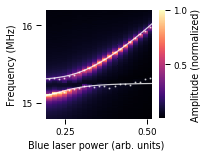

In [43]:
### Make paper-style figure

sns.set_context('paper') # makes text appropriate
### Normalized amplitude, paper-style
plt.figure(figsize=(2.5,2))
normconst = ((p.iloc[:-1]).max().max());
#dk = np.linspace(0, peakfreqsp.index.values.max(), 500)
ax = myheatmap((p.iloc[:-1]/normconst).transpose(), 'Amplitude (normalized)')
peakfreqsp.plot(color='white', alpha = .6, marker = '.', markersize=2, linestyle= 'None', linewidth=0.5, legend=False, ax=ax)
plt.ylabel("Frequency (MHz)")
plt.xlabel("Blue laser power (arb. units)")
#plt.title(file + '\n')
plt.plot(dk**.5,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.5,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.ylim(14.8, 16.2)
#plt.xlim(3,9.4)

if saving_all:
    ## save pdf of figure
    plt.savefig(os.path.join(savefolder,file + '_fit.pdf'), dpi=None, facecolor='w', edgecolor='w',
            transparent=False, bbox_inches='tight', pad_inches=0.05,
            metadata=None)

    """plt.savefig(os.path.join(savefolder,file + '_fit.svg'), dpi=None, facecolor='w', edgecolor='w',
            transparent=False, bbox_inches='tight', pad_inches=0.05,
            metadata=None)"""

    print('File saved:')
else:
    print('File not overwritten:')
print(os.path.join(savefolder,file + '_fit.pdf'))

# store info in dict
topleftgraph = {'file': file,
                'dk': dk,
                'm1': m1,
                'm2': m2,
                'k': k,
                'k1': k1,
                'xlabel': "Blue laser power (arb. units)",
                'ylabel': "Frequency (MHz)",
                'ylims': (14.8, 16.2),
                'heatmapdf': (p.iloc[:-1]/normconst).transpose(), 
                'datapoints': peakfreqsp,
               }

sns.set_context('poster') # makes text larger going forward.
#del m1,m2,k,k1,dk

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


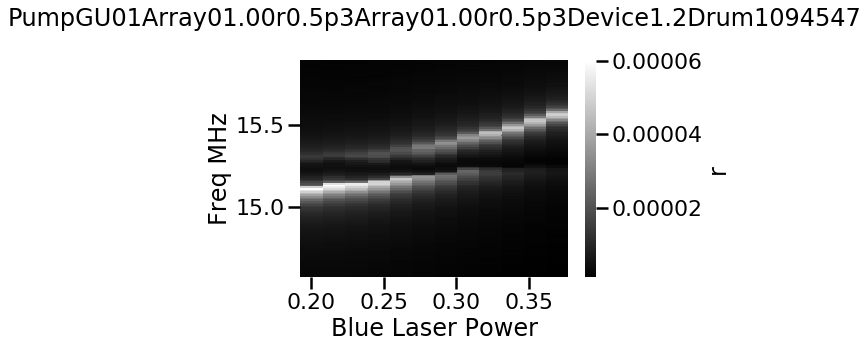

In [44]:
lf = df['Freq MHz'] > 14.57 
hf = df['Freq MHz'] < 15.9 
lv = df['Blue Laser Power'] > 0.1
hv = df['Blue Laser Power'] < 0.38
n = df[lf][hf][lv][hv].pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
myheatmap(n.transpose(), cmap = 'gray', colorbarlabel='r')
plt.title(file + '\n');

In [45]:

# initialize peaks list
peaksint = []
freqlist = []

verbose = False

for i in range(len(n)):
    res = detect_peaks(n.iloc[i], 
             mph=5e-6, 
           #  threshold=1e-8,
             mpd=2,
             edge = 'both',
             show=verbose)
    #print(res)
    freqlist.append(n.columns[res[-2:]])
    # shorten results to just 2 peaks
    peaksint.append(res[-2:])
    #print(peaksint[i])
    
#display(peaksint)

peakfreqsn = pd.DataFrame(freqlist, index = n.index, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqsn


,peak1 freq [MHz],peak2 freq [MHz]
Blue Laser Power,,
0.369231,15.212425,15.563126
0.353846,15.212425,15.523046
0.338462,15.202405,15.482966
0.323077,15.212425,15.452906
0.307692,15.222445,15.422846
0.292308,15.192385,15.392786
0.276923,15.182365,15.362725
0.261538,15.172345,15.352705
0.246154,15.142285,15.322645


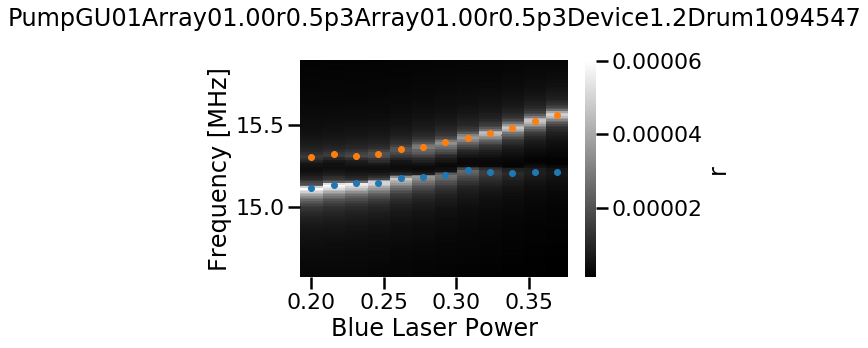

In [46]:
# To change the colors in the pcolormesh, add the pcolormesh argument: cmap = cmap
#cmap = sns.cubehelix_palette(n_colors = 1, start=0, rot=1, light=1, as_cmap=True)
#cmap = sns.cubehelix_palette( light=1, as_cmap=True)
#cmap = sns.color_palette("Grey", as_cmap=True)

ax = myheatmap(n.transpose(), 'r', cmap='gray')
peakfreqsn.plot(ax=ax, marker = '.', linestyle='None', legend=False)
plt.ylabel("Frequency [MHz]");
plt.title(file + '\n');

Measuring at driving resonator (R1)
     Closest at 0.1992009945926565 MHz, at 6.492660248009977 V
     Frequency closest at: 15.27808760368916 MHz and 15.477288598281817 MHz
Measuring at tiny resonator (R2)
     Closest at 0.2176815957644198 MHz, at 6.831498774921255 V
     Frequency closest at: 15.460396348684808 MHz and 15.678077944449228 MHz


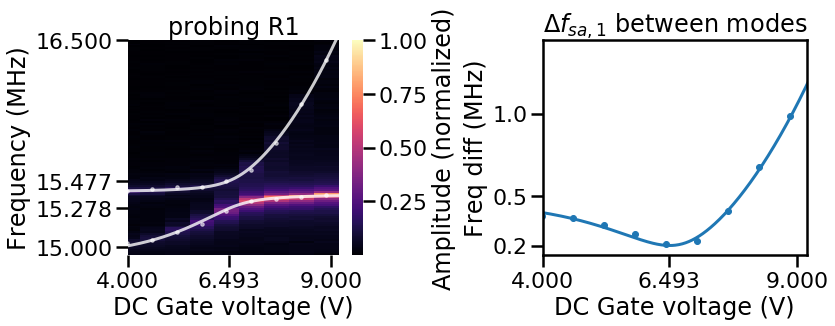

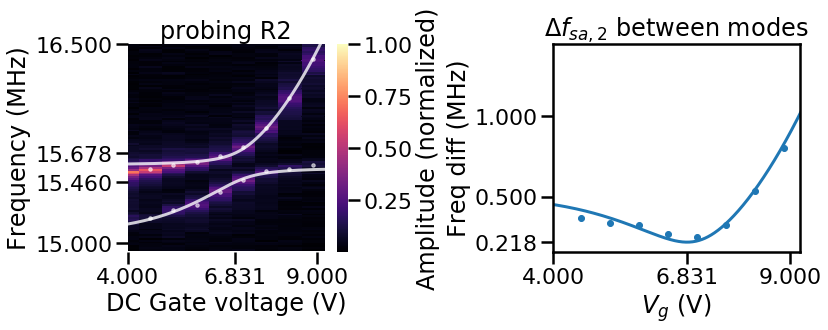

In [47]:
linesty = {'color':'white', 'alpha': .8}
pointssty = {'color':'white', 'alpha': .6, 'marker': '.', 'markersize':7, 'linestyle': 'None', 'legend':False, }
cmap = 'magma'

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

dk = bigdrum_V['dk']
m1 = bigdrum_V['m1']
m2 = bigdrum_V['m2']
k = bigdrum_V['k']
k1 = bigdrum_V['k1']

voltageaxis1 = dk**.25
differencecurveR1 = upperantifn(dk, m1,m2,k,k1) - lowerantifn(dk, m1,m2,k,k1)
closetsval1, idx1 = min((val, idx) for (idx, val) in enumerate(differencecurveR1))


plt.sca(ax2) ## I don't know why it only works if I plot the second graph first.
p = plt.plot(voltageaxis1,differencecurveR1 )
plt.xlabel("DC Gate voltage (V)")
plt.ylabel('Freq diff (MHz)')
plt.xlim(bigdrum_V['xlims'])
#plt.xticks(bigdrum_V['xticks'])
plt.title('$\Delta f_{sa,1}$ between modes')
plt.xticks([4,voltageaxis1[idx1],9])
plt.yticks([1.5,1, .5, closetsval1])
plt.plot(bigdrum_V['datapoints'][1] - bigdrum_V['datapoints'][0], '.', color = p[0].get_color())

plt.sca(ax1)

myheatmap(bigdrum_V['heatmapdf'], 'Amplitude (normalized)', cmap = cmap)
bigdrum_V['datapoints'].plot(**pointssty, ax=ax1)
plt.ylabel("Frequency (MHz)")
plt.xlabel("DC Gate voltage (V)")
#plt.title(file + '\n')

plt.plot(voltageaxis1,lowerantifn(dk, m1,m2,k,k1), **linesty)
plt.plot(voltageaxis1,upperantifn(dk, m1,m2,k,k1), **linesty)

#plt.ylim(14.8, 16.2)
#plt.xlim(bigdrum_V['xlims'])
#plt.ylim(bigdrum_V['ylims'])
#plt.xticks(bigdrum_V['xticks'])
plt.title('probing R1')
plt.xticks([4,voltageaxis1[idx1],9])
plt.yticks([15,lowerantifn(dk[idx1], m1,m2,k,k1), upperantifn(dk[idx1], m1,m2,k,k1), 16.5])

plt.tight_layout()

print('Measuring at driving resonator (R1)')
print('     Closest at ' + str(closetsval1) + (' MHz, at ') + str(voltageaxis1[idx1]) + ' V')
print('     Frequency closest at: ' + str(lowerantifn(dk[idx1], m1,m2,k,k1)) + ' MHz and '
     + str(upperantifn(dk[idx1], m1,m2,k,k1)) + ' MHz')

fig, (ax3, ax4) = plt.subplots(1,2, figsize = (12,5))

dk = tinydrum_V['dk']
m1 = tinydrum_V['m1']
m2 = tinydrum_V['m2']
k = tinydrum_V['k']
k1 = tinydrum_V['k1']

voltageaxis2 = dk**.25
differencecurveR2 = upperantifn(dk, m1,m2,k,k1) - lowerantifn(dk, m1,m2,k,k1)
closetsval2, idx2 = min((val, idx) for (idx, val) in enumerate(differencecurveR2))

plt.sca(ax4)
plt.plot(voltageaxis2, upperantifn(dk, m1,m2,k,k1) - lowerantifn(dk, m1,m2,k,k1))
plt.xlabel("$V_g$ (V)")
plt.ylabel('Freq diff (MHz)')
plt.xlim(tinydrum_V['xlims'])
plt.xticks(tinydrum_V['xticks'])
plt.title('$\Delta f_{sa,2}$ between modes')
plt.xticks([4,voltageaxis2[idx2],9])
plt.yticks([1.5,1, .5, closetsval2])
plt.plot(tinydrum_V['datapoints'][1] - tinydrum_V['datapoints'][0], '.', color = p[0].get_color())


plt.sca(ax3)

myheatmap(tinydrum_V['heatmapdf'], 'Amplitude (normalized)', cmap = cmap)
tinydrum_V['datapoints'].plot(**pointssty, ax=ax3)
plt.ylabel("Frequency (MHz)")
plt.xlabel("DC Gate voltage (V)")
#plt.title(file + '\n')

plt.plot(voltageaxis2,lowerantifn(dk, m1,m2,k,k1), **linesty)
plt.plot(voltageaxis2,upperantifn(dk, m1,m2,k,k1), **linesty)

#plt.ylim(14.8, 16.2)
#plt.xlim(tinydrum_V['xlims'])
plt.xticks(tinydrum_V['xticks'])
plt.title('probing R2')
plt.xticks([4,voltageaxis2[idx2],9])
#plt.yticks([15,lowerantifn(dk[idx2], m1,m2,k,k1), upperantifn(dk[idx2], m1,m2,k,k1),17])
plt.yticks([15,lowerantifn(dk[idx2], m1,m2,k,k1), upperantifn(dk[idx2], m1,m2,k,k1),16.5])


print('Measuring at tiny resonator (R2)')
print('     Closest at ' + str(closetsval2) + (' MHz, at ') + str(voltageaxis2[idx2]) + ' V')
#print('at ' + str(dk) + ' V')
print('     Frequency closest at: ' + str(lowerantifn(dk[idx2], m1,m2,k,k1)) + ' MHz and '
     + str(upperantifn(dk[idx2], m1,m2,k,k1)) + ' MHz')

sharedxlim = [4,9.2]
sharedylim = [14.938,16.5]

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xlim(sharedxlim)
    
for ax in [ax1,ax3]:
    ax.set_ylim(sharedylim)

plt.tight_layout()



NameError: name 'cbar2' is not defined

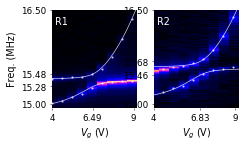

In [48]:
sns.set_context('paper')
cm = 1/2.54  # centimeters to inches

#subplotssty = {'figsize': (4,3), "constrained_layout":True} # constrained was bad!
subplotssty = {'figsize': (8.5*cm,1.8)}

tickwidth = .5
cbarticklength = 1
plotticklength = 2

fig, (ax4,ax2) =plt.subplots(1,2, **subplotssty)

linesty = {'color':'white', 'linewidth':0.7, 'alpha': .8}
pointssty = {'color':'white', 'alpha': .6, 'marker': '.', 'markersize':2.5, 'linestyle': 'None', 'legend':False, }
cmap = 'gnuplot2'
cbarlabel = None
freqlabel = 'Freq. (MHz)'
#cbarlabel = 'Amplitude\n(normalized)'

# big drum, versus voltage
plt.sca(ax4)
dk = bigdrum_V['dk']
m1 = bigdrum_V['m1']
m2 = bigdrum_V['m2']
k = bigdrum_V['k']
k1 = bigdrum_V['k1']
#_, cbar4 = myheatmap(bigdrum_V['heatmapdf'], cbarlabel, cmap = cmap, return_cbar=True, 
#                     cbarargs={'drawedges':False, 'orientation':'horizontal'})
myheatmap(bigdrum_V['heatmapdf'], cmap=cmap, draw_cbar=False)

bigdrum_V['datapoints'].plot(**pointssty, ax=ax4)
ylims = plt.ylim()
plt.ylabel(freqlabel)
plt.xlabel("$V_g$ (V)")
#print(file)
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1),**linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)
#plt.xlim(3,9.4)
plt.annotate("R1", (4.2, 16.4), color='w', va='top')
ax4.set_xticks([4,voltageaxis1[idx1],9])
ax4.set_xticklabels(['4',str(voltageaxis1[idx1].round(2)) ,'9']) ## make SURE this line is with the one above it
plt.yticks([15,
            lowerantifn(dk[idx1], m1,m2,k,k1).round(2),
            upperantifn(dk[idx1], m1,m2,k,k1).round(2), 
            16.5])

#plt.ylim(bigdrum_V['ylims'])
#del m1,m2,k,k1,dk
#plt.xticks([3,6,9])

## little drum, versus voltage
plt.sca(ax2)
dk = tinydrum_V['dk']
m1 = tinydrum_V['m1']
m2 = tinydrum_V['m2']
k = tinydrum_V['k']
k1 = tinydrum_V['k1']
#_,cbar2 = myheatmap(tinydrum_V['heatmapdf'],cbarlabel, cmap = cmap, return_cbar=True)
myheatmap(tinydrum_V['heatmapdf'], cmap=cmap, draw_cbar=False)

"""plt.pcolormesh( listwrap(tinydrum_V['heatmapdf'].columns),
                   listwrap(tinydrum_V['heatmapdf'].index), 
                   tinydrum_V['heatmapdf'], cmap=cmap)
ax2.set_frame_on(False)"""
"""cbarargs={'drawedges':False, 'orientation':'horizontal'}
cbar2 = plt.colorbar(**cbarargs)
cbar2.outline.set_visible(False)
#cbar2.set_label(cbarlabel)"""

tinydrum_V['datapoints'].plot(**pointssty, ax=ax2)
plt.ylabel(None)
plt.xlabel("$V_g$ (V)")
#plt.title(file + '\n')

plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), **linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)

#plt.ylim(14.8, 16.2)
#plt.xlim(tinydrum_V['xlims'])
plt.xticks(tinydrum_V['xticks'])
#plt.title('probing R2')
plt.annotate("R2", (4.2, 16.4), color='w', va='top')
ax2.set_xticks([4,voltageaxis2[idx2],9])
ax2.set_xticklabels(['4',str(voltageaxis2[idx2].round(2)) ,'9']) ## make SURE this line is with the one above it

#plt.yticks([15,lowerantifn(dk[idx2], m1,m2,k,k1), upperantifn(dk[idx2], m1,m2,k,k1),17])
plt.yticks([15,
            lowerantifn(dk[idx2], m1,m2,k,k1).round(2), 
            upperantifn(dk[idx2], m1,m2,k,k1).round(2),
            16.5])



for ax in [ax2,ax4]:
    ax.tick_params(direction='out', length=plotticklength, width=tickwidth)
    ax.set_xlim(sharedxlim)
    ax.set_ylim(sharedylim)

for cbar in [ cbar2,  cbar4]:
    cbar.ax.tick_params(length=cbarticklength, width=tickwidth)


plt.tight_layout()

#saving = True
savefile = 'two_anticrossing_figures_fit.pdf'

#saving=True
if saving:
    ## save pdf of figure
    plt.savefig(os.path.join(savefolder,savefile), dpi=None, facecolor='w', edgecolor='w',
            transparent=False, bbox_inches='tight', pad_inches=0.05,
            metadata=None)

    print('File saved:')
else:
    print('File not overwritten:')
print(os.path.join(savefolder,savefile))

sns.set_context('poster')

In [ ]:
# poster sized
fig, ((ax1, ax2), (ax3, ax4)) =plt.subplots(2,2, figsize=(15,10))

linesty = {'color':'white', 'alpha': .8}
pointssty = {'color':'white', 'alpha': .6, 'marker': '.', 'markersize':7, 'linestyle': 'None', 'legend':False, }
cmap = 'viridis'

## top left plot
plt.sca(ax1)
dk = topleftgraph['dk']
m1 = topleftgraph['m1']
m2 = topleftgraph['m2']
k = topleftgraph['k']
k1 = topleftgraph['k1']
myheatmap(topleftgraph['heatmapdf'], 'Amplitude (normalized)', cmap = cmap )
topleftgraph['datapoints'].plot(**pointssty, ax=ax1)
plt.plot(dk**.5,lowerantifn(dk, m1,m2,k,k1), **linesty)
plt.plot(dk**.5,upperantifn(dk, m1,m2,k,k1), **linesty)
plt.ylabel(topleftgraph['ylabel'])
plt.xlabel('Blue laser power (arb. units)')
plt.ylim(topleftgraph['ylims']);

## little drum, versus voltage
plt.sca(ax2)
dk = tinydrum_V['dk']
m1 = tinydrum_V['m1']
m2 = tinydrum_V['m2']
k = tinydrum_V['k']
k1 = tinydrum_V['k1']
ax2 = myheatmap(tinydrum_V['heatmapdf'], 'Amplitude (normalized)', cmap = cmap)
tinydrum_V['datapoints'].plot(**pointssty, ax=ax2)
plt.ylabel("Frequency (MHz)")
plt.xlabel("DC Gate voltage (V)")
#plt.title(file + '\n')

plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), **linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)

#plt.ylim(14.8, 16.2)
plt.xlim(tinydrum_V['xlims'])
plt.xticks(tinydrum_V['xticks'])

# little drum, versus laser
plt.sca(ax3)
dk = tinydrum_laser['dk']
m1 = tinydrum_laser['m1']
m2 = tinydrum_laser['m2']
k = tinydrum_laser['k']
k1 = tinydrum_laser['k1']
ax = myheatmap(tinydrum_laser['heatmapdf'], 'Amplitude (normalized)', cmap = cmap)
tinydrum_laser['datapoints'].plot(**pointssty, ax=ax3)
plt.ylabel("Frequency (MHz)")
plt.xlabel("Blue laser power (arb. units)")
#plt.plot(dk**.5,lowerantifn(dk, m1,m2,k,k1), **linesty)
#plt.plot(dk**.5,upperantifn(dk, m1,m2,k,k1), **linesty)
plt.ylim(15,)


# big drum, versus voltage
plt.sca(ax4)
dk = bigdrum_V['dk']
m1 = bigdrum_V['m1']
m2 = bigdrum_V['m2']
k = bigdrum_V['k']
k1 = bigdrum_V['k1']
myheatmap(bigdrum_V['heatmapdf'], 'Amplitude\n(normalized)', cmap = cmap)
bigdrum_V['datapoints'].plot(**pointssty, ax=ax4)
ylims = plt.ylim()
plt.ylabel("Frequency (MHz)")
plt.xlabel("DC Gate voltage (V)")
#print(file)
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1),**linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)
plt.xlim(3,9.4)
plt.ylim(bigdrum_V['ylims'])
#del m1,m2,k,k1,dk

plt.tight_layout()

In [ ]:
sns.set_context('paper')

#subplotssty = {'figsize': (4,3), "constrained_layout":True} # constrained was bad!
subplotssty = {'figsize': (4,3)}

tickwidth = .5
cbarticklength = 1
plotticklength = 2

fig, ((ax1, ax2), (ax3, ax4)) =plt.subplots(2,2, **subplotssty)

linesty = {'color':'white', 'linewidth':0.7, 'alpha': .8}
pointssty = {'color':'white', 'alpha': .6, 'marker': '.', 'markersize':2.5, 'linestyle': 'None', 'legend':False, }
cmap = 'gnuplot2'
cbarlabel = None
freqlabel = 'Freq. (MHz)'
#cbarlabel = 'Amplitude\n(normalized)'

#bluepowerlabel = 'Blue laser power (arb. units)'
bluepowerlabel = 'Pump power (arb. units)'

## top left plot
plt.sca(ax1)
dk = topleftgraph['dk']
m1 = topleftgraph['m1']
m2 = topleftgraph['m2']
k = topleftgraph['k']
k1 = topleftgraph['k1']
_, cbar1 = myheatmap(topleftgraph['heatmapdf'], cbarlabel, cmap = cmap, return_cbar=True)
topleftgraph['datapoints'].plot(**pointssty, ax=ax1)
plt.plot(dk**.5,lowerantifn(dk, m1,m2,k,k1), **linesty)
plt.plot(dk**.5,upperantifn(dk, m1,m2,k,k1), **linesty)
plt.ylabel(freqlabel)
plt.xlabel(bluepowerlabel)
plt.ylim(topleftgraph['ylims']);
plt.yticks([15,16])

## little drum, versus voltage
plt.sca(ax2)
dk = tinydrum_V['dk']
m1 = tinydrum_V['m1']
m2 = tinydrum_V['m2']
k = tinydrum_V['k']
k1 = tinydrum_V['k1']
_,cbar2 = myheatmap(tinydrum_V['heatmapdf'],cbarlabel, cmap = cmap, return_cbar=True)
tinydrum_V['datapoints'].plot(**pointssty, ax=ax2)
plt.ylabel(freqlabel)
plt.xlabel("DC Gate voltage (V)")
#plt.title(file + '\n')

plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), **linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)

#plt.ylim(14.8, 16.2)
plt.xlim(tinydrum_V['xlims'])
plt.xticks(tinydrum_V['xticks'])

# little drum, versus laser
plt.sca(ax3)
dk = tinydrum_laser['dk']
m1 = tinydrum_laser['m1']
m2 = tinydrum_laser['m2']
k = tinydrum_laser['k']
k1 = tinydrum_laser['k1']
_,cbar3 = myheatmap(tinydrum_laser['heatmapdf'],cbarlabel, cmap = cmap, return_cbar=True)
tinydrum_laser['datapoints'].plot(**pointssty, ax=ax3)
plt.ylabel(freqlabel)
plt.xlabel(bluepowerlabel)
#plt.plot(dk**.5,lowerantifn(dk, m1,m2,k,k1), **linesty)
#plt.plot(dk**.5,upperantifn(dk, m1,m2,k,k1), **linesty)
plt.ylim(15,)


# big drum, versus voltage
plt.sca(ax4)
dk = bigdrum_V['dk']
m1 = bigdrum_V['m1']
m2 = bigdrum_V['m2']
k = bigdrum_V['k']
k1 = bigdrum_V['k1']
_, cbar4 = myheatmap(bigdrum_V['heatmapdf'], cbarlabel, cmap = cmap, return_cbar=True)
bigdrum_V['datapoints'].plot(**pointssty, ax=ax4)
ylims = plt.ylim()
plt.ylabel(freqlabel)
plt.xlabel("DC Gate voltage (V)")
#print(file)
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1),**linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)
plt.xlim(3,9.4)
plt.ylim(bigdrum_V['ylims'])
#del m1,m2,k,k1,dk
plt.xticks([3,6,9])

for ax in [ax1,ax2,ax3,ax4]:
    ax.tick_params(direction='out', length=plotticklength, width=tickwidth)

for cbar in [cbar1, cbar2, cbar3, cbar4]:
    cbar.ax.tick_params(length=cbarticklength, width=tickwidth)


plt.tight_layout()

#saving = True
savefile = 'anticrossing_figures_fit.pdf'


if saving_all:
    ## save pdf of figure
    plt.savefig(os.path.join(savefolder,savefile), dpi=None, facecolor='w', edgecolor='w',
            transparent=False, bbox_inches='tight', pad_inches=0.05,
            metadata=None)

    print('File saved:')
else:
    print('File not overwritten:')
print(os.path.join(savefolder,savefile))

sns.set_context('poster')

In [ ]:
#Define column names and read csv file

if Vivaflag:
    base1 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\ResonanceCurves'
    base2 = base1
    file1 = 'Array01.00r0.5p3Device1.2Drum1Couping500\Data.csv'
    file2 = 'Array01.00r0.5p3Device1.2RandomNodeCoupling500\Data.csv'
else:
    base1 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
    base2 = base1
    
    file1 = 'Array01.00r0.5p3Device1.2Drum1Couping500/Data.csv'
    file2 = 'Array01.00r0.5p3Device1.2RandomNodeCoupling500/Data.csv'

path1 = os.path.join(base1, file1)
path2 = os.path.join(base2, file2)

colnames= ['SweepVal', 'F', 'R', 'theta', 'NEP_BW', 'R_ref', 'theta_ref', 'Amp', 'Phase']

df1 = pd.read_csv(path1, names = colnames)
df2 = pd.read_csv(path2, names = colnames)

#Fit linear part of phase lag to subtract from graph

#Define normalized data for fitting
maxR1 = df1['R'].max()
df1['Rnorm'] = (df1.R) / (maxR1)
df1['Fnorm'] = df1.F / 10**6
df1['Rnorm2']= ((df1.R)/maxR1)**2

df2['Rnorm'] = (df2.R) / (maxR1)
df2['Fnorm'] = df2.F / 10**6
df2['Rnorm2']= ((df2.R)/maxR1)**2

#Definte linear portion of less than 15MHz for fit
mk = df1.Fnorm < 15

x1 = df1[['Fnorm']][mk]
y1 = df1.theta[mk]

x2 = df2[['Fnorm']][mk]
y2 = df2.theta[mk]

#Perform linear fit
model1 = LinearRegression().fit(x1,y1)
r_sq1 = model1.score(x1,y1)

model2 = LinearRegression().fit(x2,y2)
r_sq2 = model2.score(x2,y2)

df1['thetaLin'] = df1.theta - model2.intercept_ - model2.coef_ * df2.Fnorm
df1['radLin'] = df1.thetaLin * np.pi / 180
df1['wrap'] = np.unwrap(df1.radLin)

df2['thetaLin'] = df2.theta - model2.intercept_ - model2.coef_ * df2.Fnorm
df2['radLin'] = df2.thetaLin * np.pi / 180
df2['wrap'] = np.unwrap(df2.radLin)

#Define all variables

#individual springs that correspond to individual masses
#k1, k2 = (0.0063, 0.0063)
k1 = (0.0063)
k2 = sp.symbols('k_2')

#springs that connect two masses
#k12 = 6*10**-6
k12 = sp.symbols('k_12')

#damping coefficients and forc
g1, g2 = (5*10**4,5*10**4)
 
#masses
#m1, m2 = (2.7*10**-17, 2.725*10**-17)
#m1, m2 = sp.symbols('m_1, m_2')
m1 = 2.7*10**-17
m2 = sp.symbols('m_2')

#Driving force amplitude
F = (3*10**-5)

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d')

#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), -k12/m1], [-k12/m2, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([[F/m1, -k12/m1], [0, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

driven_m2 = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), F/m1], [-k12/m2, 0]])

#Apply Cramer's Rule
Cr1, Cr2 = (driven_m1.det()/driven.det(),driven_m2.det()/driven.det())

#Solve for phases for each mass
delta1 = sp.arg(Cr1)
delta2 = sp.arg(Cr2)

#Wrap phases for plots

wrap1 = (delta1)%(2*np.pi)
wrap2 = (delta2)%(2*np.pi)

#Solve for amplitude coefficients
amp1 = sp.re(Cr1)/sp.cos(delta1)
amp2 = sp.re(Cr2)/sp.cos(delta2)

#lambdify curves

c1 = sp.lambdify((wd, k2, k12, m2),amp1)
t1 = sp.lambdify((wd, k2, k12, m2),wrap1)
c2 = sp.lambdify((wd, k2, k12, m2),amp2)
t2 = sp.lambdify((wd, k2, k12, m2),wrap2)

#define functions

def curve1(w, k_2, k_12, m_2):
     return c1(w, k_2, k_12, m_2)
    
def theta1(w, k_2, k_12, m_2, d):
     return t1(w, k_2, k_12, m_2) - 2*np.pi + d
    
def curve2(w, k_2, k_12, m_2):
     return c2(w, k_2, k_12, m_2)
    
def theta2(w, k_2, k_12, m_2, d):
     return t2(w, k_2, k_12, m_2) - 2*np.pi + d
    
#Definte data

x1 = df1.F.values
y1 = df1.Rnorm.values
th1 = df1.wrap.values

x2 = df2.F.values
y2 = df2.Rnorm.values
th2 = df2.wrap.values

def residual(params, w1, w2, data_amp1, data_phase1, data_amp2, data_phase2):
    k_2 = params['k2']
    k_12 = params['k12']
    m_2 = params['m2']
    d = params['d']
    
    model1 = curve1(w1, k_2, k_12, m_2)
    model2 = theta1(w1, k_2, k_12, m_2, d)
    model3 = curve2(w2, k_2, k_12, m_2)
    model4 = theta2(w2, k_2, k_12, m_2, d)
    
    resid1 = data_amp1 - model1
    resid2 = data_phase1 - model2
    resid3 = data_amp2 - model3
    resid4 = data_phase2 - model4

    return np.concatenate((resid1, resid2, resid3, resid4))

params2 = lmfit.Parameters()
params2.add('k2', value = 0.0063)
params2.add('k12', value = 6*10**-5)
params2.add('m2', value = 2.7*10**-17)
params2.add('d', value = 0.2)

out = lmfit.minimize(residual, params2, args = (x1, x2, y1, th1, y2, th2))

k_2 = out.params['k2'].value
k_12 = out.params['k12'].value
m_2 = out.params['m2'].value
d = out.params['d'].value

print(lmfit.fit_report(out))



In [ ]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(3, 2, figsize = (3,4))

#subplotssty = {'figsize': (4,3), "constrained_layout":True} # constrained was bad!
#subplotssty = {'figsize': (2,2)}

tickwidth = .5
cbarticklength = 1
plotticklength = 2


linesty = {'color':'white', 'linewidth':0.7, 'alpha': .8}
pointssty = {'color':'white', 'alpha': .6, 'marker': '.', 'markersize':2.5, 'linestyle': 'None', 'legend':False,  }

cmap = 'gnuplot2'
cbarlabel = None
freqlabel = 'Freq. (MHz)'



ax1.plot(x1/(1e6), y1, '.', markersize = 2.5, color = m1_col)
ax1.plot(x1/(1e6), curve1(x1, k_2, k_12, m_2), '-', color='black', linewidth = 0.7)
ax1.set_xlabel('Freq (MHz)')
ax1.set_ylabel('Amplitude (a.u)')

ax2.plot(x1/(1e6), th1/np.pi, '.', markersize = 2.5, color = m1_col)
ax2.plot(x1/(1e6), theta1(x1, k_2, k_12, m_2, d)/np.pi, '-', color='black', linewidth = 0.7)
ax2.set_xlabel('Freq (MHz)')
ax2.set_ylabel('Phase (pi rad)')

plt.sca(ax3)
dk = bigdrum_V['dk']
m1 = bigdrum_V['m1']
m2 = bigdrum_V['m2']
k = bigdrum_V['k']
k1 = bigdrum_V['k1']
_, cbar4 = myheatmap(bigdrum_V['heatmapdf'], cbarlabel, cmap = cmap, return_cbar=True)
bigdrum_V['datapoints'].plot(**pointssty, ax=ax3)
ylims = plt.ylim()
plt.ylabel(freqlabel)
plt.xlabel("DC Gate voltage (V)")
#print(file)
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1),**linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)
plt.xlim(3,9.4)
#plt.ylim(bigdrum_V['ylims'])
#del m1,m2,k,k1,dk
plt.xticks([3,6,9])

ax4.plot(x2/(1e6), y2, '.', markersize = 2.5, color = m2_col)
ax4.plot(x1/(1e6), curve2(x2, k_2, k_12, m_2), '-', color='black', linewidth = 0.7)
ax4.set_xlabel('Freq (MHz)')
ax4.set_ylabel('Amplitude (a.u)')

ax5.plot(x2/(1e6), th2/np.pi, '.', markersize = 2.5, color = m2_col)
ax5.plot(x1/(1e6), theta2(x2, k_2, k_12, m_2, d)/np.pi, '-', color='black', linewidth = 0.7)
ax5.set_xlabel('Freq (MHz)')
ax5.set_ylabel('Phase (pi rad)')


plt.sca(ax6)
dk = tinydrum_V['dk']
m1 = tinydrum_V['m1']
m2 = tinydrum_V['m2']
k = tinydrum_V['k']
k1 = tinydrum_V['k1']
_,cbar2 = myheatmap(tinydrum_V['heatmapdf'],cbarlabel, cmap = cmap, return_cbar=True)
tinydrum_V['datapoints'].plot(**pointssty, ax=ax6)
plt.ylabel(freqlabel)
plt.xlabel("DC Gate voltage (V)")
#plt.title(file + '\n')

plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), **linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)

#plt.ylim(14.8, 16.2)
plt.xlim(tinydrum_V['xlims'])
plt.xticks(tinydrum_V['xticks'])

for ax in [ax2,ax5,ax3,ax4,ax1]:
    ax.tick_params(direction='out', length=plotticklength, width=tickwidth)

for cbar in [cbar2, cbar4]:
    cbar.ax.tick_params(length=cbarticklength, width=tickwidth)



plt.tight_layout()

if saving:
    if Vivaflag:
        savefolder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports'
        savefile = 'Figure2Curves_vertical,notstacked.pdf'

        plt.savefig(os.path.join(savefolder,savefile), dpi=None, facecolor='w', edgecolor='w',
            transparent=False, bbox_inches='tight', pad_inches=0.05,
            metadata=None)
        print('Saved file:')
        print(os.path.join(savefolder,savefile))
    else:
        fig.savefig('/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/Figure2Curves_vertical,notstacked.pdf', bbox_inches= 'tight', pad_inches=0.05)
else:
    print('Figure2Curves_vertical,notstacked.pdf not overwritten')


In [ ]:
# Stacked Plots for paper
sp.init_printing(use_latex ='mathjax')
import matplotlib.gridspec as gridspec
sns.set_context('paper', rc = {'font.size':8, 'axes.titlesize':8, "axes.labelsize":8, 'xtick.labelsize':8, 'ytick.labelsize': 8})

m1_col = "#2A4F98"
m2_col = "#E4A52D"

#subplotssty = {'figsize': (4,3), "constrained_layout":True} # constrained was bad!
subplotssty = {'figsize': (2.5,3)}

tickwidth = .5
cbarticklength = 1
plotticklength = 2


linesty = {'color':'white', 'linewidth':0.7, 'alpha': .8}
pointssty = {'color':'white', 'alpha': .6, 'marker': '.', 'markersize':2.5, 'linestyle': 'None', 'legend':False,   }
cmap = 'gnuplot2'
cbarlabel = None
freqlabel = 'Freq. (MHz)'


fig = plt.figure(figsize = (3.4,3.4))

gs0 = gridspec.GridSpec(5,2)

gs00 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec= gs0[0:3,0], hspace = 0)
ax0 = fig.add_subplot(gs00[0])
ax0.plot(x1/(1e6), y1, '.', markersize = 2.5, color = m1_col)
ax0.plot(x1/(1e6), curve1(x1, k_2, k_12, m_2), '-', color='black', linewidth = 0.7)
ax0.set_ylabel('Amp (a.u)')
ax0.axes.xaxis.set_visible(False)

ax1 = fig.add_subplot(gs00[1])
ax1.plot(x1/(1e6), th1, '.', markersize = 2.5, color = m1_col)
ax1.plot(x1/(1e6), theta1(x1, k_2, k_12, m_2, d), '-', color='black', linewidth = 0.7)
plt.ylim(ymax = .3*np.pi)
ax1.set_yticks([-np.pi, 0]) # make sure this line is joined with the one below it.
ax1.set_yticklabels(['$-$\u03C0', '0 '])  # make sure this line is joined with the one above it.
ax1.set_xlabel('Freq (MHz)')
ax1.set_ylabel('Phase')

gs10 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = gs0[3:5,0])
ax2 = fig.add_subplot(gs10[0])
plt.sca(ax2)
dk = bigdrum_V['dk']
m1 = bigdrum_V['m1']
m2 = bigdrum_V['m2']
k = bigdrum_V['k']
k1 = bigdrum_V['k1']
_, cbar4 = myheatmap(bigdrum_V['heatmapdf'], cbarlabel, cmap = cmap, return_cbar=True)
bigdrum_V['datapoints'].plot(**pointssty, ax=ax2)
ylims = plt.ylim()
plt.ylabel(freqlabel)
plt.xlabel("DC Gate voltage (V)")
#print(file)
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1),**linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)
plt.xlim(3,9.4)
plt.ylim(bigdrum_V['ylims'])
#del m1,m2,k,k1,dk
plt.xticks([3,6,9])

ax4.plot(x2/(1e6), y2, '.', markersize = 2.5, color = m2_col)
ax4.plot(x1/(1e6), curve2(x2, k_2, k_12, m_2), '-', color='black', linewidth = 0.7)
ax4.set_xlabel('Freq (MHz)')
ax4.set_ylabel('Amplitude (a.u)')


gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec = gs0[0:3,1], hspace = 0)
ax3 = fig.add_subplot(gs01[0])
ax3.plot(x1/(1e6), y2, '.', markersize = 2.5, color = m2_col)
ax3.plot(x1/(1e6), curve2(x1, k_2, k_12, m_2), '-', color='black', linewidth = 0.7)
ax3.set_ylabel('Amp (a.u)')
ax3.axes.xaxis.set_visible(False)

ax4 = fig.add_subplot(gs01[1])
ax4.plot(x1/(1e6), th2, '.', markersize = 2.5, color = m2_col)
ax4.plot(x1/(1e6), theta2(x1, k_2, k_12, m_2, d), '-', color='black', linewidth = 0.7)
#(top,bottom) = plt.ylim()
plt.ylim(ymax = .5*np.pi) # adjust so zeros aren't too close
ax4.set_yticks([-2*np.pi, -np.pi, 0]) # make sure this line is joined with the one below it
ax4.set_yticklabels(['$-$2\u03C0', '$-$\u03C0', '0 '])  # make sure this line is joined with the one above it.
ax4.set_xlabel('Freq (MHz)')
ax4.set_ylabel('Phase')


gs11 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = gs0[3:5,1])
ax5b = fig.add_subplot(gs11[0])
plt.sca(ax5b)
dk = tinydrum_V['dk']
m1 = tinydrum_V['m1']
m2 = tinydrum_V['m2']
k = tinydrum_V['k']
k1 = tinydrum_V['k1']
_,cbar2 = myheatmap(tinydrum_V['heatmapdf'],cbarlabel, cmap = cmap, return_cbar=True)
tinydrum_V['datapoints'].plot(**pointssty, ax=ax5b)
plt.ylabel(freqlabel)
plt.xlabel("DC Gate voltage (V)")
#plt.title(file + '\n')

plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), **linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)

#plt.ylim(14.8, 16.2)
plt.xlim(tinydrum_V['xlims'])
plt.xticks(tinydrum_V['xticks'])

for ax in [ax2,ax5,ax5b,ax3,ax4,ax0,ax1]:
    ax.tick_params(direction='out', length=plotticklength, width=tickwidth)

for cbar in [cbar2, cbar4]:
    cbar.ax.tick_params(length=cbarticklength, width=tickwidth)



plt.tight_layout()

if saving:
    if Vivaflag:
        savefolder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports'
        savefile = 'Figure2Curves_stacked.pdf'
        import matplotlib.pyplot as plt 
        plt.savefig(os.path.join(savefolder,savefile), dpi=None, facecolor='w', edgecolor='w',
            transparent=False, bbox_inches='tight', pad_inches=0.05,
            metadata=None)
        print('Saved file:')
        print(os.path.join(savefolder,savefile))
    else:
        fig.savefig('/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/Figure2Curves_Version2.pdf', bbox_inches= 'tight', pad_inches=0.05)
else:
    print('Figure2Curves_stacked.pdf not overwritten')

